<a href="https://www.kaggle.com/code/brandonowens24/shotquality-3pt-competition?scriptVersionId=208821381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RUN_CELL = False

Importing libraries.

In [3]:
# General
import re
import gc
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import math

# Visualizations
from io import BytesIO

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPolygon
from matplotlib.collections import PatchCollection
import seaborn as sns

from PIL import Image

from shapely.geometry.polygon import orient
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from PIL import Image


# Advanced Feature Engineering
from joblib import Parallel, delayed
from tqdm.contrib.concurrent import process_map
from sklearn.impute import KNNImputer
from shapely.geometry import Polygon

# Modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

2024-11-21 13:10:23.477605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 13:10:23.477772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 13:10:23.676266: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


***

# **Quantifying NCAAM 3PT Defense with Tracking Data**

At its inception, basketball was not the known to be the dynamic and physical sport it has become today. From the evolution of play strategy, dunking, rule advancement, and the shot clock, one could argue that the most relevant change to the game came in 1986 with the induction of the three-point line (NCAA). In the last few years, the three-point shot has completely revolutionzed the game -- making it almost indistinguishable from that of Naismith's original implementation. The game is now faster and more skilled than ever. Shooting the three is no longer an option, but a necessity for teams to succeed. Thus, the challenge presented in this competition involves quantification of schemas and player abilities that contribute to the lowest 3PT% on individual shots. 

## Dataset

There are three datasets for usage of this challenge:
1. *Play-by-Play (PBP)*: Contains play-level details outlining team names and whether the shot was made.

2. *Location (Loc)*: On-court locations of each player, along with an indicator to show whether the player is the shooter, an offensive player, or a defensive player.
    * Broken into two categories:
        * Location: The location information at the moment of the shot.
        * Tracking: The location information at the moment of a specified frame from within the source video.
        
## Objective

Given the data provided, the task is to create a model to distinguish the impact of defensive and offensive movements using tracking data to predict whether a three-point shot attempt will be successful or not. This objective is to be measured using a ROC AUC score.

## Approach

While digging in to this problem, I have used my technical skills and background knowledge of the game of basketball to tackle this problem involving the following strategies:

1. Feature Engineering
    * *Distance Features*: Calculation of distances between the shooter and the basket, the shooter and the ith closest teammate, the ith closest teammate and their closest defender, the ith closest defender, and the ith closest defender with their closest player that they are defending.
    * *Angles*: Calculation of angles of players with respect to the "basket line" (from hoop to hoop) and calculation of player relative angles to the shooter and their closeset opposition.
    * *Spacing*: Developed features regarding the convex hull of each team's players with respect to the basket.
    * *Player Ability*: Including tracking the min, max, std, and avg speed and distance travelled for each classification of player.
2. Modeling
    * *Hyperparameter Tuning*: Tuning hyperparameters.
    * *Model Exploration*: Testing multiple modeling techniques including logistic regression, xgboost, neural networks, etc.


## Table of Contents
**IN PROGRESS**

1. **[Load In Data](#dataload)**
2. **[EDA Part I: Univariate Analysis and Cleaning](#EDAptI)**
3. **[Train-Test Split](#tts)**
4. **[Frame Counts per Play](#fcpp)**
5. **[Target Percentages](#tp)**
6. **[Distance to the Basket](#dtb)**
7. **[Filtering](#f)**
8. **[Shot Distances Histogram](#sdh)**
9. **[Shooting Densities Heatmap](#sdhe)**
10. **[The Null Model](#null)**
11. **[EDA Part II: Multivariate Analysis and Advanced Feature Engineering](#EDAptII)**
12. **[Binned Distance Shooting Percentages](#bdsp)**
13. **[Shooting Percentages vs Court Coordinates](#spvcc)**
14. **[Advanced Feature Engineering: Distances, Angles, and Player Relativity](#af)**
15. **[Floor Spacing](#fs)**
16. **[Defensive Density](#density)**
17. **[Player Distances and Speed Over Time](#speed)**
18. **[Missing Values](#miss)**
19. **[Modeling](#model)**





***

# Load In Data <a name="dataload"></a>

In [4]:
# loading in play-by-play data
train_pbp = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/train_pbp.csv")
test_pbp = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/test_pbp.csv")

In [5]:
# loading in location data -- when the 3pt attempt is shot
train_loc = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/train_locations.csv")
test_loc = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/test_locations.csv")

In [6]:
# loading in location data -- tracking leading up to the shot attempt.
train_tracking = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/train_tracking.csv")
test_tracking = pd.read_csv("/kaggle/input/quantifying-3-pt-def-in-ncaam-with-tracking-data/new_Archive/test_tracking.csv")

Examination

In [7]:
print(train_pbp.info(), train_loc.info(), train_tracking.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25211 entries, 0 to 25210
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  25211 non-null  int64
 1   game_id     25211 non-null  int64
 2   play_id     25211 non-null  int64
 3   Target      25211 non-null  int64
dtypes: int64(4)
memory usage: 788.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247794 entries, 0 to 247793
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   game_id          247794 non-null  int64  
 1   play_id          247794 non-null  int64  
 2   annotation_code  247794 non-null  object 
 3   court_x          247794 non-null  float64
 4   court_y          247794 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 9.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40537291 entries, 0 to 40537290
Data columns (total 7 columns):
 # 

In [8]:
train_pbp.head()

,Unnamed: 0,game_id,play_id,Target
0,0,19788163519851,140,0
1,1,19784044514721,39,0
2,2,19802017303901,3,0
3,3,19795020019121,60,0
4,4,19791129615141,113,0


In [9]:
train_loc.head(6)

,game_id,play_id,annotation_code,court_x,court_y
0,19783001319551,6,d1,5.710743,34.122727
1,19783001319551,6,d2,5.287258,14.042897
2,19783001319551,6,d3,9.318427,6.612670
3,19783001319551,6,d4,13.188732,17.685114
4,19783001319551,6,d5,21.786111,25.203976
5,19783001319551,6,s,10.767019,1.721625


In [10]:
train_tracking.head()

,game_id,play_id,type,frame,x,y,tracklet_id
0,19783001319551,6,teammate,72200,24.4789,26.2661,1
1,19783001319551,6,teammate,72201,24.3773,25.9362,1
2,19783001319551,6,teammate,72202,24.8440,25.9456,1
3,19783001319551,6,teammate,72203,24.7808,26.1066,1
4,19783001319551,6,teammate,72204,24.7371,25.9108,1


Observations:

PBP Data:
* Although referenced in the competition description, there is no reference towards a team's name or identification.
* Contains our `Target` variable that we are looking to compare to.
* Contains ~25,000 plays for us to use as training data.
* No missing data.

Location Data:
* Is ultra-specific regarding x and y coordinates.
* No missing data.


***

# EDA Part I: Univariate Analysis and Cleaning <a name="EDAptI"></a>

## Train-Test Split <a name="tts"></a>
Let's start with our training and testing split! This will be important for determining a future cross-validation split and the proportion of new data in which we will not train our model on.

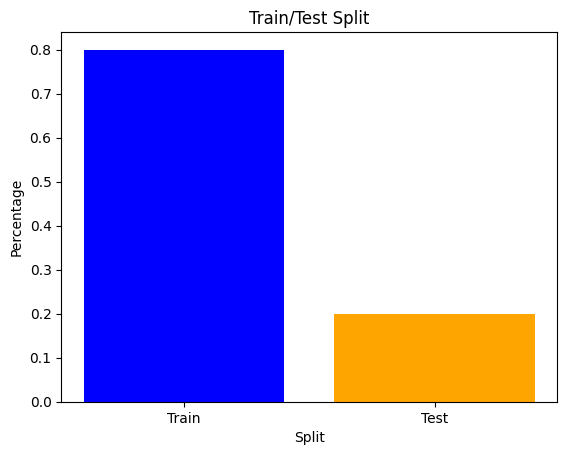

In [11]:
tot = len(train_pbp) + len(test_pbp)

plt.bar(x=["Train", "Test"], height=[len(train_pbp)/tot, len(test_pbp)/tot], color=['blue', 'orange'])
plt.xlabel('Split')
plt.ylabel('Percentage')
plt.title('Train/Test Split')
plt.show()

## Frame Counts Per Play <a name="fcpp"></a>
Let's get a feel for how many total frames were captured for each play. This is useful information because it gives us a sense at the context that the ShotQuality computer vision was able to pick up. More importantly, how much temporal data we will be working with for each of these plays.

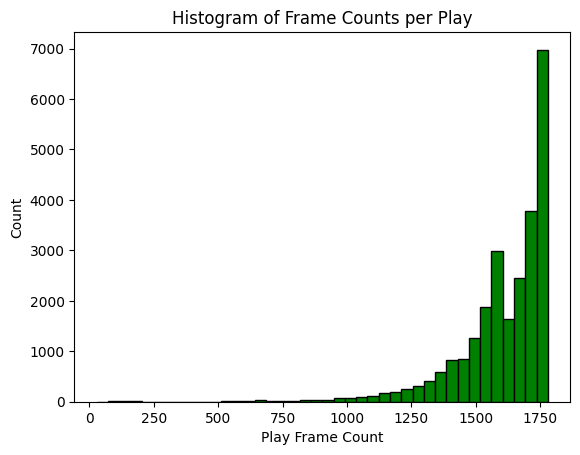

8971

In [12]:
# Create a temporary df to see how many frame counts per game occur.
fpg = train_tracking.sort_values("game_id").value_counts(["game_id", "play_id"]).reset_index(name="Count")

# Plot
plt.hist(fpg["Count"], bins=40, color="green", edgecolor="black")
plt.xlabel('Play Frame Count')
plt.ylabel('Count')
plt.title('Histogram of Frame Counts per Play')
plt.show()

# Garbage Collection
del fpg
gc.collect()

**Histogram of Frame Counts per Play Analysis:**

*Observations:*

* Skewed left
* The more frames per play, logically the more information regarding defensive and offensive schemes and player intuition/movement.
* It may be beneficial to filter out plays where all five players are not present on tracking (less frames).


In [13]:
print(len(test_pbp))
print(len(test_loc[test_loc.annotation_code=="s"]))

6303
6255


**Note:** There are about 48 instances where the shooter is not present in the testing set.

## Target Percentages <a name="tp"></a>

Next, let's see what percentage of our training data results in the defense failing to stop the three. This could be useful information for future testing as if the target shooting is very low, we may have to oversample makes.

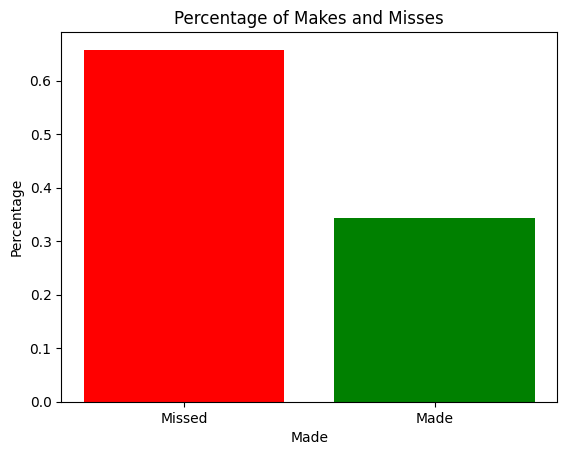

2821

In [14]:
made = train_pbp["Target"].value_counts(normalize=True)

plt.bar(made.index, made.values, color=['red', 'green'])
plt.xlabel('Made')
plt.ylabel('Percentage')
plt.title('Percentage of Makes and Misses')
plt.xticks([0, 1], labels=['Missed', 'Made']) 
plt.show()

del made
gc.collect()

**Pct of Makes and Misses Analysis:**

*Observations:*

* Teams seem to shoot an average of ~**35%** from downtown within our training set. While this may seem unbalanced, it fits pretty nicely with legitimate collegiate averages.
* Potential to oversamples makes as a way to get a better understanding of what is allowing offensive players the ability to score more instead of their natural affinity to lean towards a miss.

## Distance to the Basket <a name="dtb"></a>

Before we do any multivariate analysis, let's define a euclidian distance function to be able to obtain some things for *filtering* and future *feature engineering*. It will be useful to different things such as
* How far away teammates are from one another.
* How far away defenders are from offensive players.
* Player distance from the basket.
    * Ensure data collected is a three pointer.
    * To be used as a feature itself.

In [15]:
def euclidian_distance(x1, y1, x2, y2):
    '''
    Takes two sets of coordinates and returns their euclidian distance.
    
    Input(s):
        - x1(float): First item's x coordinate.
        - y1(float): First item's y coordinate.
        - x2(float): Second item's x coordinate.
        - y2(float): Second item's y coordinate.
        
    Returns:
        - euc_dis(float): Euclidian distance apart.
    '''
    
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

Let's start by grabbing the relevant players of when the shooter is actually shooting further than the three point line.
This information is obtained by comparing the euclidian distance of the player from the basket vs. the euclidian distance of the player to the three point line.

* If the shooter shoots on the left side of the court, we will compare distances with the `(4, 25)` basket. 
* If theshooter shoots on the right side of the court, we will compare distances with the `(90, 25)` basket.

In [16]:
# Determine the distance of a three-point shot (same on both ends of the floor).
thpt_dist = euclidian_distance(4, 25, 27.4, 25)

## For training data
# Filter shooter rows and set basket condition
shooter_basket = train_loc[train_loc["annotation_code"] == "s"].assign(basket=lambda df: np.where(df["court_x"] >= 47, 1, 0))[["game_id", "play_id", "basket"]]

# Merge back after obtaining shooter side
train_loc = train_loc.merge(shooter_basket, on=["game_id", "play_id"], how="left")

# Null handling
mean_court_x = train_loc.groupby(["game_id", "play_id"])["court_x"].transform('mean')
train_loc["basket"] = np.where(train_loc["basket"].isna(),
    np.where(mean_court_x >= 47, 1, 0),
    train_loc["basket"])

# Obtain distances from the basket
train_loc["dist_to_basket"] = train_loc.apply(
    lambda row: euclidian_distance(row["court_x"], row["court_y"], 4, 25) if row["basket"] == 0 else euclidian_distance(row["court_x"], row["court_y"], 90, 25),axis=1)

## For testing data
# Filter shooter rows and set basket condition
shooter_basket = test_loc[test_loc["annotation_code"] == "s"].assign(basket=lambda df: np.where(df["court_x"] >= 47, 1, 0))[["game_id", "play_id", "basket"]]

# Merge back after obtaining shooter side
test_loc = test_loc.merge(shooter_basket, on=["game_id", "play_id"], how="left")

# Null handling
mean_court_x = test_loc.groupby(["game_id", "play_id"])["court_x"].transform('mean')
test_loc["basket"] = np.where(test_loc["basket"].isna(),
    np.where(mean_court_x >= 47, 1, 0),
    test_loc["basket"])

# Obtain distances from the basket
test_loc["dist_to_basket"] = test_loc.apply(
    lambda row: euclidian_distance(row["court_x"], row["court_y"], 4, 25) if row["basket"] == 0 else euclidian_distance(row["court_x"], row["court_y"], 90, 25), axis=1)


Let's see an example of this feature:

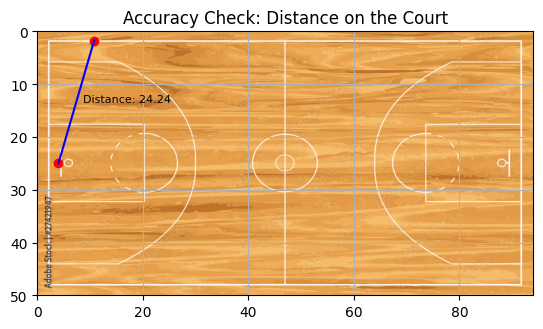

In [17]:
# Create image from the internet
url = "https://as2.ftcdn.net/v2/jpg/00/27/42/19/1000_F_27421947_OjxwPFPycRJSOaLSyHeXTr75GpsXAzeP.jpg"
img = Image.open(BytesIO(requests.get(url).content))

# Sample example x,y, and distances
x, y, distance = train_loc[5:6]["court_x"], train_loc[5:6]["court_y"], train_loc[5:6]["dist_to_basket"]
x, y, distance = float(x.iloc[0]), float(y.iloc[0]), float(distance.iloc[0])

# Establish figure and image
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 94,50,0])


# Example plot for first play shooter.
ax.plot([x, 4], [y, 25], 'ro')
ax.plot([x, 4], [y, 25], 'b-')
ax.text((17), (y + 25) / 2, f'Distance: {distance:.2f}', fontsize=8, ha='center')
plt.grid(True)
plt.title("Accuracy Check: Distance on the Court")
plt.show()

## Filtering <a name="f"></a>

Let's do some more cleaning. Here, we are only interested in plays where...
* The shot is taken from outside of the three point line (`player distance from basket` > `three point distance from basket`).
* Any player doesn't stray too far out of bounds.


In [18]:
# Shots tracked inside of three point distance changed to three point distance with leeway
invalid_combinations1 = train_loc.loc[((train_loc.annotation_code == "s") & (train_loc.dist_to_basket < int(thpt_dist-3)))]
train_loc = train_loc[~train_loc.set_index(['game_id', 'play_id']).index.isin(invalid_combinations1.set_index(['game_id', 'play_id']).index)]

# Filter instances where a player is abnormally far out of bounds.
train_loc = train_loc.loc[~((train_loc['court_x'] < -20) | (train_loc['court_x'] > 114) | (train_loc['court_y'] < -20) | (train_loc['court_y'] > 70))]

# Have the tracking df only include plays in the loc df
train_tracking = train_tracking.loc[(train_tracking.game_id.isin(train_loc.game_id)) & (train_tracking.play_id.isin(train_loc.play_id))]

After checking earlier and seeing that the testing dataset contains 48 plays without a shooter tracked, we are going to actually not filter out plays where less players are on the court as our testing data appears to have instances where players are missing. Instead, we will account for the size of how many players are tracked in each play after we have committed our filtering.

In [19]:
# Adding number of tracked players on offense and defense for training data
train_loc["defensive_count"] = train_loc[train_loc["annotation_code"].str.startswith('d')].groupby(["game_id", "play_id"])["annotation_code"].transform('size')
train_loc["offensive_count"] = train_loc[(train_loc["annotation_code"].str.startswith('t') | train_loc["annotation_code"].str.startswith('s'))].groupby(["game_id", "play_id"])["annotation_code"].transform('size')

# Adding number of tracked players on offense and defense for testing data
test_loc["defensive_count"] = test_loc[test_loc["annotation_code"].str.startswith('d')].groupby(["game_id", "play_id"])["annotation_code"].transform('size')
test_loc["offensive_count"] = test_loc[(test_loc["annotation_code"].str.startswith('t') | test_loc["annotation_code"].str.startswith('s'))].groupby(["game_id", "play_id"])["annotation_code"].transform('size')

## Shot Distances Histogram <a name="sdh"></a>

This one is self explanatory -- how far out are the shooters shooting from?

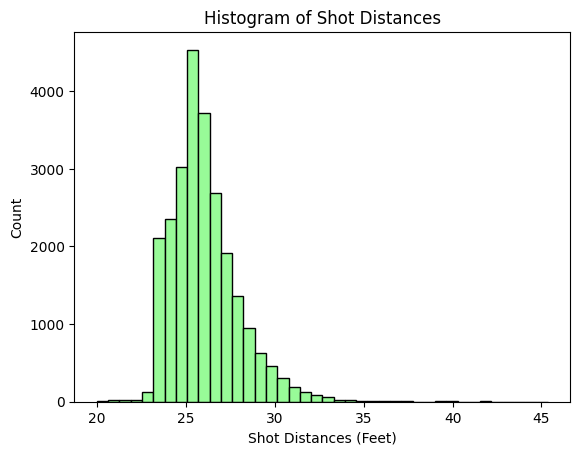

In [20]:
# Plot
plt.hist(train_loc[train_loc.annotation_code == "s"]["dist_to_basket"], bins=40, color="palegreen", edgecolor="black")
plt.xlabel('Shot Distances (Feet)')
plt.ylabel('Count')
plt.title('Histogram of Shot Distances')
plt.show()

**Histogram of Frame Counts per Play Analysis:**

*Observations:*

* Skewed right. This makes sense because it's not often you have somebody chucking up a fifty-footer on a set play.
* The majority of shots are actually coming from 2+ feet behind the three point line. It would be nice to be able to tell if the players were catching and squaring up or pulling up off of the dribble.
* There are some tracked shots within a foot or two of the three point line, but we are going to leave them. There might have been slight error with the tracking software.


## Shooting Densities Heatmap <a name="sdhe"></a>

Now, let's build a heatmap to see the most common locations where shooters are deciding they have good looks from.

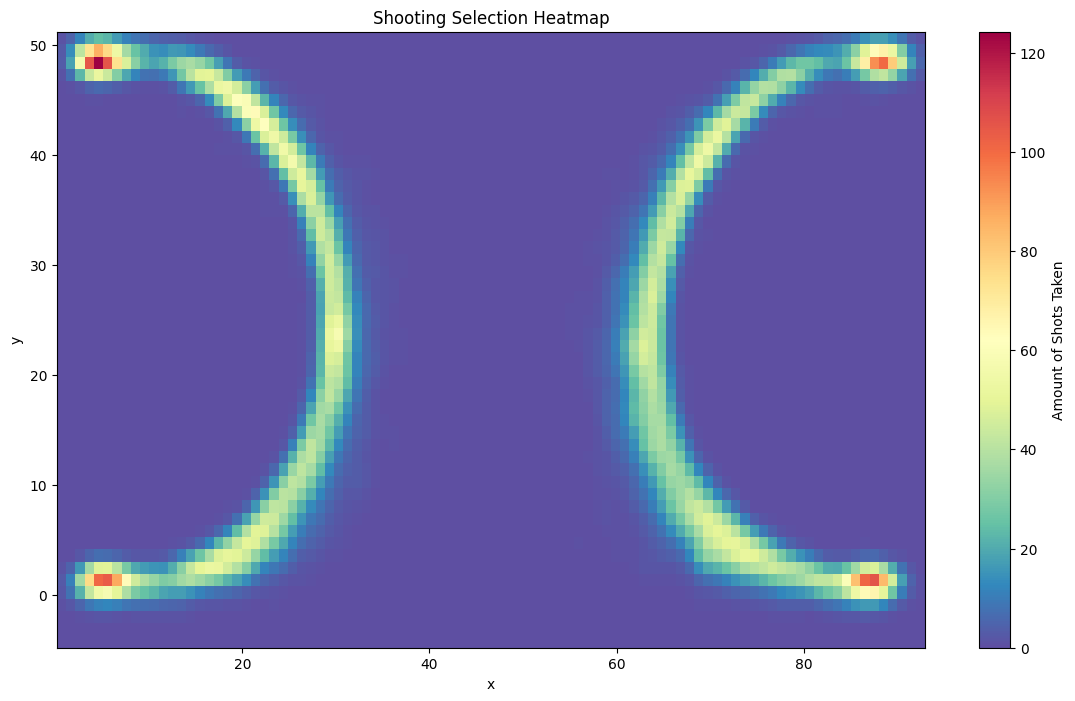

In [21]:
# Create a temporary DataFrame where we can manipulate x and y values
tmp = pd.merge(train_loc[train_loc.annotation_code == "s"], train_pbp, on=["game_id", "play_id"])

x = tmp['court_x']
y = tmp['court_y']

# 2d histogram of data created
hist, xedges, yedges = np.histogram2d(x, y, bins=[94, 50])

# Gaussian filter for smoothing
hist_smoothed = gaussian_filter(hist, sigma=0.8)

# Plot
plt.figure(figsize=(14, 8))
plt.imshow(hist_smoothed.T, origin='lower', cmap="Spectral_r", aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Amount of Shots Taken')
plt.title('Shooting Selection Heatmap')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Shooting Selection Heatmap Analysis:**

*Observations*:

* We already knew there was a very small number of shots taken from around midcourt.
* Our distance outside of the three point line filter works well!
* **Shooters love sagging down to those corners!** (perhaps favorint the right side)

In [22]:
# Aggregation of training and testing for any new features being added.
train_tracking["set"] = "train"
test_tracking["set"] = "test"
train_loc["set"] = "train"
test_loc["set"] = "test"
train_pbp["set"] = "train"
test_pbp["set"] = "test"

track_df = pd.concat([train_tracking, test_tracking])
loc_df = pd.concat([train_loc, test_loc])
pbp_df = pd.concat([train_pbp, test_pbp])

# For future use (much easier to use a copy)
loc_df2 = loc_df.copy()

# Garbage Collection
del train_tracking, test_tracking, train_loc, test_loc, train_pbp, test_pbp
gc.collect()

11259

***

# **The Null Model** <a name="null"></a>

With any future models that we create, how are we able to identify if our process is actually making improvements? Sure, we can simply make a randomized prediction on whether a shot will be made or not, but even then an individual can infer more logic than simply assigning a 50-50 (or in our case a 35-65) probability to a make. 

Thus, utilizing some of our simple data to create a baseline model for future model comparison will be extremely beneficial to see if our complexity of algorithm and feature engineering within our data science process is actually breeding relevant results.

Let's start with preparing our data.



In [23]:
# Merge df with X features to df with y targets.
df = pd.merge(loc_df, pbp_df, how="left", on=["play_id", "game_id", "set"])

In [24]:
# Merge df with X features to df with y targets.
df_train = df[(df.annotation_code == "s") & (df.set == "train")]

# Convert features and targets to numpy arrays. This should help for faster processing.
X = df_train["dist_to_basket"].to_numpy()
X = X.reshape(-1, 1)
y = df_train["Target"].to_numpy()

# Scale X features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

roc_auc_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

How should we model our baseline model? Because it's a baseline model, let's keep it simple and just stick with logit.

Even though Logistic Regression is known to be the sort of "first step" with regards to supervised learning, that doesn't mean we should discount it at all.

*Perks of a Logistic Regression:*
* Extremely easy to set up and understand.
* We are only inputting two featues at the moment. There's no need to utilize an overcomplicated model for a baseline with such simple inputs.
* Very powerful and fast for binary classification problems.

Therefore, we will create a  simple logistic regression model for this problem!

In [25]:
model = LogisticRegression(random_state=821)

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred)
    
    roc_auc_scores.append(roc_auc)

In [26]:
np.mean(roc_auc_scores)

0.5146484733570263

*Baseline Model Analysis:*

A **`0.5146`** is better than a 0.5000 ROC-AUC (albeit, just barely). This isn't horrible though for a baseline model. It's a step above merely taking a uninform guess for every three point shot attempt. Instead, we were able to implement a very inferential features to make this logistic regression make a slightly more informed guess on the effectiveness of 3pt defense.

Let's see what features and modeling techniques we can develop to beat it!


***

# EDA Part II: Multivariate Analysis and Advanced Feature Engineering <a name="EDAptII"></a>

## Binned Distance Shooting Percentages <a name="bdsp"></a>

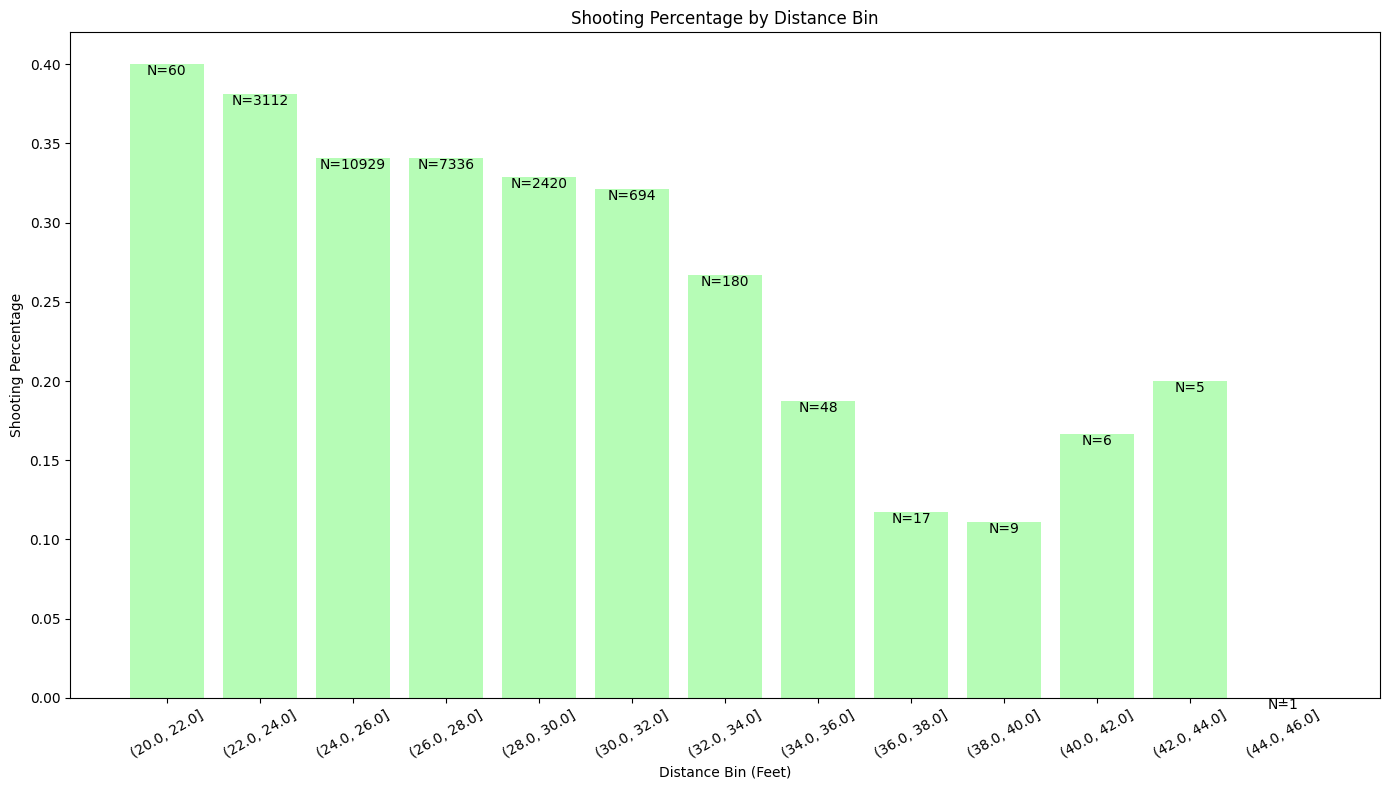

In [27]:
# Create desired temporary df
tmp = pd.merge(loc_df[(loc_df.annotation_code == "s") & (loc_df.set == "train")], pbp_df[pbp_df.set == "train"], on=["game_id", "play_id"])

# Create bins
bins = np.linspace(20, 46, 14)
tmp['dist_bin'] = pd.cut(tmp['dist_to_basket'], bins=bins)

# Obtain binned shooting percentagtes
tmp = tmp.groupby('dist_bin').agg(shooting_percentage=('Target', 'mean'), shot_count=('Target', 'size')).reset_index()

# Plot
plt.figure(figsize=(14, 8))
bars = plt.bar(tmp['dist_bin'].astype(str), tmp['shooting_percentage'], color='palegreen', alpha=0.7)

for bar, count in zip(bars, tmp['shot_count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'N={count}', 
             ha='center', va='top')


plt.xticks(rotation=30)
plt.xlabel('Distance Bin (Feet)')
plt.ylabel('Shooting Percentage')
plt.title('Shooting Percentage by Distance Bin')
plt.tight_layout()
plt.show()

**Shooting Distance Percentages**

*Observations*:

* The data has pretty consistent shooting around that 35% within 4 feet of the three-point line (although they are a little better the closer you get). After that, the percentages begin to fall. We will look at the impact of defenders on this data as well in the following sections.

## Shooting PCTs vs Court Coordinates <a name="spvcc"></a>

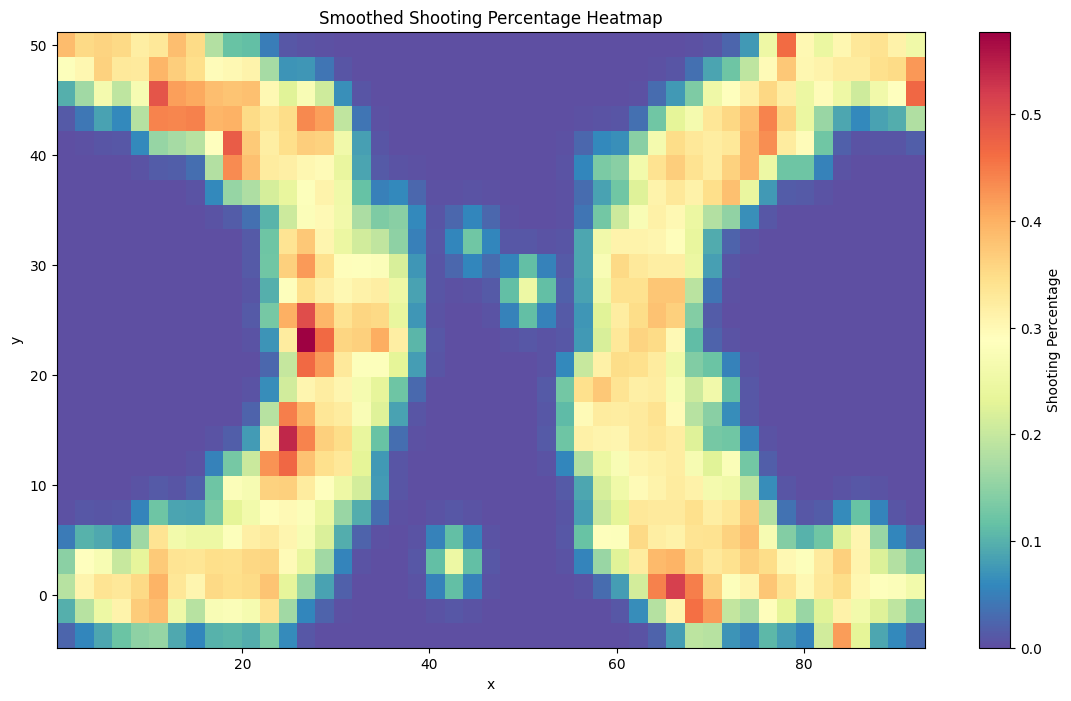

In [28]:
# Create a temporary DataFrame where we can manipulate x and y values
tmp = pd.merge(loc_df[(loc_df.annotation_code == "s") & (loc_df.set == "train")], pbp_df[pbp_df.set == "train"], on=["game_id", "play_id"])

x = tmp['court_x']
y = tmp['court_y']
z = tmp['Target']

# 2 histogram of data created, weighted by the shooting percentage
hist, xedges, yedges = np.histogram2d(x, y, bins=[47, 25], weights=z)

# Normalize the histogram 
attempt_hist, _, _ = np.histogram2d(x, y, bins=[47, 25])
with np.errstate(divide='ignore', invalid='ignore'):
    hist = np.divide(hist, attempt_hist, where=attempt_hist != 0)

# Gaussian filter for smoothing
hist_smoothed = gaussian_filter(hist, sigma=0.8)

# Plot
plt.figure(figsize=(14, 8))
plt.imshow(hist_smoothed.T, origin='lower', cmap="Spectral_r", aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Shooting Percentage')
plt.title('Smoothed Shooting Percentage Heatmap')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Shooting Selection Percentages Heatmap Analysis:**

*Observations*:

* Right free-throw line extended appears to be a very high shooting percentage location (dependent on how many shots were taken there).
* There are random zones with a few percent higher than the average. Specifically the right side and the top of the key.
* The further out the shot, the lower the percentage.

## Advanced Feature Engineering: Distances, Angles, Player Relativity <a name="af"></a>

Based on my previous knowledge of basketball, I know that it's a game of inches and angles. Thus, we should develop some features that take into account player distances from each other, and with respect to the opposing teams. Outside of distances, it would be helpful to see the player angles relative to the basket and each other! Let's dive in.

In [29]:
def side_of_floor(x, y, basket):
    '''
    Function that determines the side of the floor that the play is occurring on.
    
    Inputs:
        - x (float): x coordinate
        - y (float): y coordinate
    
    Returns
        - bool: 1 for right side. 0 for left side.
    '''
    
    if basket:
        if y > 25:
            return 1
    else:
        if y < 25:
            return 1
    return 0

def side_of_court(x, y):
    '''
    Function that determines the side of halfcourt that the player is on at the time of the shot.
    
    Inputs:
        - x (float): x coordinate
        - y (float): y coordinate
    
    Returns
        - bool: 1 for right side. 0 for left side.
    '''
    if x > 47:
        return 1
    else:
        return 0

### Calculations for Determining Angles <a name="cfda"></a>

In [30]:
def compute_bask_mid_angle(x, y, basket):
    '''
    Function that computes the angle of a player with respect to an invisible line running down the center of the court from basket to basket.
    
    Inputs:
        - x (float): x coordinate
        - y (float): y coordinate
        - basket (bool): 0 or 1 for which basket the player is scoring on
        
    Returns:
        - angle (float): Degree angle with respect to players and the basket line.
    '''
    
    if not basket:
        if y > 25:
            return math.degrees(math.atan2(y-25, x))
        else:
            return math.degrees(math.atan2(25-y, x))
    else:
        if y < 25:
            return math.degrees(math.atan2(25-y, 94-x))
        else:
            return math.degrees(math.atan2(y-25, 94-x))

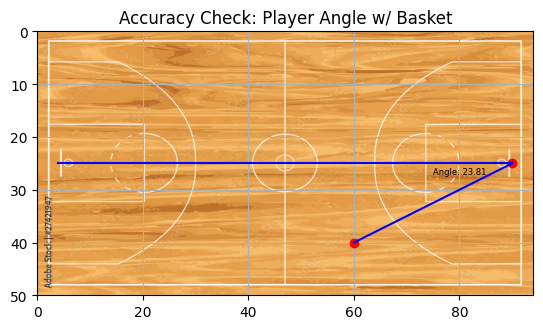

In [31]:
# Create image from the internet
url = "https://as2.ftcdn.net/v2/jpg/00/27/42/19/1000_F_27421947_OjxwPFPycRJSOaLSyHeXTr75GpsXAzeP.jpg"
img = Image.open(BytesIO(requests.get(url).content))

# Sample example x,y, and distances
x, y, angle = 60, 40, compute_bask_mid_angle(60, 40, 1)

# Establish figure and image
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 94,50,0])

# Example plot for first play shooter.
ax.plot([x, 90], [y, 25], 'ro')
ax.plot([x, 90], [y, 25], 'b-')
ax.plot([4, 90], [25, 25], 'b-')
ax.text((80), (27), f'Angle: {angle:.2f}', fontsize=6, ha='center')
plt.grid(True)
plt.title("Accuracy Check: Player Angle w/ Basket")
plt.show()

In [32]:
def rel_pos_angle(a, c, basket):
    '''
    Function that computes the angle of a player with respect to another player's position with repsect to the basket.
    
    Inputs:
        - a (tuple): coordinate for point a
        - c (tuple): coordinate for point c
        - basket (bool): 0 or 1 for which basket the player is scoring on
    Returns:
        - angle (float): Degree angle from player to opposition to basket.
    '''
    b = (90, 25) if basket else (4, 25)
    
    # Convert points to vectors
    ba = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    
    # Calculate the dot product and magnitudes
    dot_product = np.dot(ba, bc)
    magnitude_ba = np.linalg.norm(ba)
    magnitude_bc = np.linalg.norm(bc)
    
    # Calculate the cosine of the angle
    cos_angle = dot_product / (magnitude_ba * magnitude_bc)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

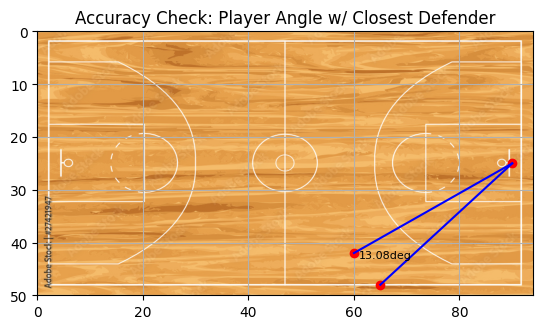

In [33]:
# Create image from the internet
url = "https://as2.ftcdn.net/v2/jpg/00/27/42/19/1000_F_27421947_OjxwPFPycRJSOaLSyHeXTr75GpsXAzeP.jpg"
img = Image.open(BytesIO(requests.get(url).content))

# Establish figure and image
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 94,50,0])

test_angle = rel_pos_angle((60, 42), (65, 48), 1)

# Example plot.
ax.plot([60, 65, 90], [42, 48, 25], 'ro')
ax.plot([60, 90], [42, 25], 'b-')
ax.plot([65, 90], [48, 25], 'b-')
ax.text(66, 43, f'{test_angle:.2f}deg', fontsize=8, ha='center')
plt.grid(True)
plt.title("Accuracy Check: Player Angle w/ Closest Defender")
plt.show()

### Determining Relativity with the Players and Capturing the "Relative" Player's Information <a name="rel"></a>

In [34]:
def rel_player_calculations(group1, group2):
    '''
    Function to find the ith closest player to the shooter on both the offensive and defensive teams, 
    and their distances, along with the closest opposing player to each ith player.
    
    Input(s):
        - group1 (Dict): Dictionary of offensive players with annotation code as the key and coordinates as values.
        - group2 (Dict): Dictionary of defensive players with annotation code as the key and coordinates as values.
    
    Returns:
        - spacing_dict (Dict): Dictionary containing the ith closest player information on both teams and 
          the closest opposing player info for each ith player.
    '''

    spacing_dict = {}
    
    # Get shooter coordinates
    try: 
        shooter_coords = group1.pop('s')  
        shooter_coords = np.array(shooter_coords)
    # Play is missing a shooter, return null df
    except: 
        return spacing_dict
    
    # Convert coordinates to numpy arrays for easier computation
    coords1 = np.array(list(group1.values()))
    coords2 = np.array(list(group2.values()))
    
    if coords1.size == 0 or coords2.size == 0:
        return spacing_dict

    # Calculate distances from shooter to all other offensive players
    shooter_distances_off = np.linalg.norm(coords1 - shooter_coords, axis=1)
    sorted_indices_off = shooter_distances_off.argsort()  # Sort by distance to shooter
    
    # Calculate distances from shooter to all defensive players
    shooter_distances_def = np.linalg.norm(coords2 - shooter_coords, axis=1)
    sorted_indices_def = shooter_distances_def.argsort()  # Sort by distance to shooter
    
    # Calculate distances between offensive and defensive players
    dist_diff_def = cdist(coords1, coords2, metric="euclidean")
    dist_diff_off = dist_diff_def.T  # To get distances from defensive to offensive players
    
    position_off = 0  # To keep track of the ith closest offensive player
    for index in sorted_indices_off:        
        off_key = list(group1.keys())[index]
        
        position_off += 1
        
        off_coords = coords1[index]
        dist_to_shooter = shooter_distances_off[index]
        
        # Find the closest opposing player to the ith closest offensive player
        dist_to_opposing = dist_diff_def[index].min()
        closest_opposing_index = dist_diff_def[index].argmin()
        closest_opposing_key = list(group2.keys())[closest_opposing_index]
        closest_opposing_coords = coords2[closest_opposing_index]
        
        spacing_dict[f'{position_off}_closest_to_shooter_off'] = {
            'annotation_code': off_key,
            'distance_to_shooter': dist_to_shooter,
            'shooter_coords': shooter_coords, 
            'coords': off_coords,
            'closest_opposing_player': closest_opposing_key,
            'distance_to_opposing': dist_to_opposing,
            'closest_opposing_coords': closest_opposing_coords
        }

    position_def = 0  # To keep track of the ith closest defensive player
    for index in sorted_indices_def:        
        def_key = list(group2.keys())[index]
        
        position_def += 1
        
        def_coords = coords2[index]
        dist_to_shooter = shooter_distances_def[index]
        
        # Find the closest opposing player to the ith closest defensive player
        dist_to_opposing = dist_diff_off[index].min()
        closest_opposing_index = dist_diff_off[index].argmin()
        closest_opposing_key = list(group1.keys())[closest_opposing_index]
        closest_opposing_coords = coords1[closest_opposing_index]
        
        spacing_dict[f'{position_def}_closest_to_shooter_def'] = {
            'annotation_code': def_key,
            'distance_to_shooter': dist_to_shooter,
            'shooter_coords': shooter_coords, 
            'coords': def_coords,
            'closest_opposing_player': closest_opposing_key,
            'distance_to_opposing': dist_to_opposing,
            'closest_opposing_coords': closest_opposing_coords
        }

        
    return spacing_dict

Processing function

In [35]:
def process_group_player_distances(group_info):
    '''
    Function that takes a grouping of players and returns a list of dictionaries with each player, their distance to the closest opponent, and a tag for whom that opponent is.

    Input(s):
        - group_info (Dict): The associated group info with your DataFrame grouping. Ex: key: (game_id, play_id), value: DataFrame
        
    Returns:
        - results (list of Dicts): List of results including the game_id, play_id, frame, closest player annotation, player annotation code, and distance to the closest opponent.
    '''
    
    (game_id, play_id), group = group_info

    # Filter groups
    g1 = group[group["annotation_code"].str.startswith('t') | (group['annotation_code'] == "s")]
    g2 = group[group["annotation_code"].str.startswith('d')]

    # Extract annotation codes and coordinates
    g1_keys = g1['annotation_code'].tolist()
    g2_keys = g2['annotation_code'].tolist()
    
    basket = (90, 25) if g1['basket'].any() else (4, 25)
    
    g1_coords = g1[['court_x', 'court_y']].values
    g2_coords = g2[['court_x', 'court_y']].values
    
    # Create dictionaries of tupled keys
    g1_dict = dict(zip(g1_keys, g1_coords))
    g2_dict = dict(zip(g2_keys, g2_coords))
    
    # Function call to get spacing information
    spacing_dict = rel_player_calculations(g1_dict, g2_dict)
    results = []
    
    
    for key, value in spacing_dict.items():
        if key:
            str_key = " ".join(key)
            results.append({
                'game_id': game_id,
                'play_id': play_id,
                'shooter_dist_to_basket': euclidian_distance(value["shooter_coords"][0], value["shooter_coords"][1], basket[0], basket[1]),
                'shooter_rel_bask_angle': compute_bask_mid_angle(value["shooter_coords"][0], value["shooter_coords"][1], g1["basket"].any()),
                'shot_r_side': side_of_floor(value["shooter_coords"][0], value["shooter_coords"][1], g1["basket"].any()),
                f'{key}': value['annotation_code'],
                f'{key}_side': side_of_floor(value["coords"][0], value["coords"][1], g1["basket"].any()),
                f'{key}_half': side_of_court(value["coords"][0], value["coords"][1]),
                f'{key}_x_y': (value["coords"][0], value["coords"][1]),
                f'{key}_dist_to_basket': euclidian_distance(value["coords"][0], value["coords"][1], basket[0], basket[1]),
                f'{key}_rel_bask_angle': compute_bask_mid_angle(value["coords"][0], value["coords"][1], g1["basket"].any()),
                f'{key}_dist_to_shooter': value['distance_to_shooter'],
                f'{key}_rel_angle_to_shooter': rel_pos_angle((value["coords"][0], value["coords"][1]), (value["shooter_coords"][0], value["shooter_coords"][1]), g1["basket"].any()),
                f'{key}_closest_opposing_player': value['closest_opposing_player'],
                f'{key}_dist_to_closest_opposing': value['distance_to_opposing'],
                f'{key}_rel_angle_to_closest_opposing': rel_pos_angle((value["coords"][0], value["coords"][1]), (value["closest_opposing_coords"][0], value["closest_opposing_coords"][1]), g1["basket"].any())
            })
        else:
            continue

    return results


Now let's apply the functions that we have created. The features that will be created from this include:

* `shooter_dist_to_basket`: How far the shooter is from the basket they are shooting on.
* `shooter_rel_bask_angle`: The shooter's relative angle with the invisible "basket-line" from basket to basket.
* `shot_r_side`: The side of the floor the shooter's shot came from.
* `{key}`: A number and tag (off/def) signifying the position of proximity to the shooter amongst a player's team.
* `{key}_side`: The side of the floor said player is on at the time of the shot.
* `{key}_half`: The half of the floor said playe is on at the time of the shot.
* `{key}_x_y`: The said player's x and y coordinates.
* `{key}_dist_to_basket`: The said player's distance to the basket.
* `{key}_rel_basket_angle`: The said player's relative angle with the invisible "basket-line" from basket to basket.
* `{key}_dist_to_shooter`: The said player's euclidian distance from the shooter.
* `{key}_rel_angle_to_shooter`: The said player's angle with the shooter where the point at the basket forms the angle.
* `{key}_closest_opposing_player`: An annotation to said player's closest opponent.
* `{key}_dist_to_closest_opposing`: The said player's distance to their closest opponent.
* `{key}_rel_angle_to_closest_opposing`: The said player's angle with the closest opponent where the point at the basket forms the angle.

In [36]:
# Create grouping for function
tmp = loc_df.groupby(["game_id", "play_id"])[["annotation_code", "court_x", "court_y", "basket"]]

# Prepare data for processing
group_data = [(key, group) for key, group in tqdm(tmp, total=len(tmp), position=0, leave=True)]

# Process with tqdm and joblib and obtain the closest player and player distance for every player
results = Parallel(n_jobs=-1)(
    delayed(process_group_player_distances)(group_info) for group_info in tqdm(group_data, total=len(group_data), position=0, leave=True)
)

# Flatten the list of results
flat_results = [item for sublist in results for item in sublist]

# Create temporary df
spacing_df = pd.DataFrame(flat_results)

100%|██████████| 31341/31341 [01:20<00:00, 388.00it/s]


In [37]:
## Processing
#Merge
loc_df = loc_df.merge(spacing_df, on=["game_id", "play_id"], how="left")

# Group the games and plays together, taking first non-null value
loc_df = loc_df.groupby(["game_id", "play_id"]).first().reset_index()

With this information, let's create some new features! In the next cell we are focused on
* `right_side_def`: The count of players on the right side of the basket being scored on.
* `left_side_def`: The count of players on the left side of the basket being scored on.
* `right_half_off`: The count of players on the right side of halfcourt.
* `left_half_off`: The count of players on the left side of halfcourt.

In [38]:
# Count of players on a side of the floor
off_cols = [col for col in loc_df.columns if any(int(n) > 0 for n in re.findall(r'^\d+', col)) and col.endswith('off_side')]
def_cols = [col for col in loc_df.columns if any(int(n) > 0 for n in re.findall(r'^\d+', col)) and col.endswith('def_side')]

loc_df["left_side_def"] = loc_df.apply(lambda row: row["defensive_count"] - sum(row[def_cols]), axis=1)
loc_df["right_side_def"] = loc_df.apply(lambda row: sum(row[def_cols]), axis=1)
loc_df["left_side_off"] = loc_df.apply(lambda row: row["offensive_count"] - sum(row[off_cols]) - row["shot_r_side"], axis=1)
loc_df["right_side_off"] = loc_df.apply(lambda row: sum(row[off_cols]) + row["shot_r_side"], axis=1)

# Count of players on a half of the floor
off_cols = [col for col in loc_df.columns if any(int(n) > 0 for n in re.findall(r'^\d+', col)) and col.endswith('off_half')]
def_cols = [col for col in loc_df.columns if any(int(n) > 0 for n in re.findall(r'^\d+', col)) and col.endswith('def_half')]

loc_df["left_half_def"] = loc_df.apply(lambda row: row["defensive_count"] - sum(row[def_cols]), axis=1)
loc_df["right_half_def"] = loc_df.apply(lambda row: sum(row[def_cols]), axis=1)
loc_df["left_half_off"] = loc_df.apply(lambda row: row["offensive_count"] - sum(row[off_cols]) - row["basket"], axis=1)
loc_df["right_half_off"] = loc_df.apply(lambda row: sum(row[off_cols]) + row["basket"], axis=1)

Now let's take some averages and standard deviations with respect to the angles gathered...

* `avg_angle_to_shooter_off`: The mean angle of the offensive players to the shooter using the basket to form the angle.
* `avg_angle_to_shooter_def`: The mean angle of the defensive players to the shooter using the basket to form the angle.
* `std_angle_to_shooter_off`: The std of the angles of offensive players to the shooter using the basket to form the angle.
* `std_angle_to_shooter_def`: The std of the angles of defensive players to the shooter using the basket to form the angle.

* `avg_angle_to_opp_off`: The mean angle of the offensive players to their closest opposition using the basket to form the angle.
* `avg_angle_to_opp_def`: The mean angle of the defensive players to their closest opposition using the basket to form the angle.
* `std_angle_to_opp_off`: The std of the angles of offensive players to their closest opposition using the basket to form the angle.
* `std_angle_to_opp_def`: The std of the angles of defensive players to their closest opposition using the basket to form the angle.


In [39]:
# Average angles to the shooter (Basket MidPoint)
off_cols = [col for col in loc_df.columns if col.endswith('off_rel_angle_to_shooter')]
def_cols = [col for col in loc_df.columns if col.endswith('def_rel_angle_to_shooter')]
loc_df["avg_angle_to_shooter_off"] = loc_df.apply(lambda row: np.mean(row[off_cols]), axis=1)
loc_df["avg_angle_to_shooter_def"] = loc_df.apply(lambda row: np.mean(row[def_cols]), axis=1)

# Std angles to the shooter (Basket Midpoint)
loc_df["std_angle_to_shooter_off"] = loc_df.apply(lambda row: np.std(row[off_cols]), axis=1)
loc_df["std_angle_to_shooter_def"] = loc_df.apply(lambda row: np.std(row[def_cols]), axis=1)

# Average angles to closest defender (Basket Midpoint)
off_cols = [col for col in loc_df.columns if col.endswith('off_rel_angle_to_closest_opposing')]
def_cols = [col for col in loc_df.columns if col.endswith('def_rel_angle_to_closest_opposing')]
loc_df["avg_angle_to_opp_off"] = loc_df.apply(lambda row: np.mean(row[off_cols]), axis=1)
loc_df["avg_angle_to_opp_def"] = loc_df.apply(lambda row: np.mean(row[def_cols]), axis=1)

# Std angles to closest defender (Basket Midpoint)
loc_df["std_angle_to_opp_off"] = loc_df.apply(lambda row: np.std(row[off_cols]), axis=1)
loc_df["std_angle_to_opp_def"] = loc_df.apply(lambda row: np.std(row[def_cols]), axis=1)


# Drop unnecessary cols
loc_df.drop(columns=["annotation_code", "court_x", "court_y", "dist_to_basket"], inplace=True)

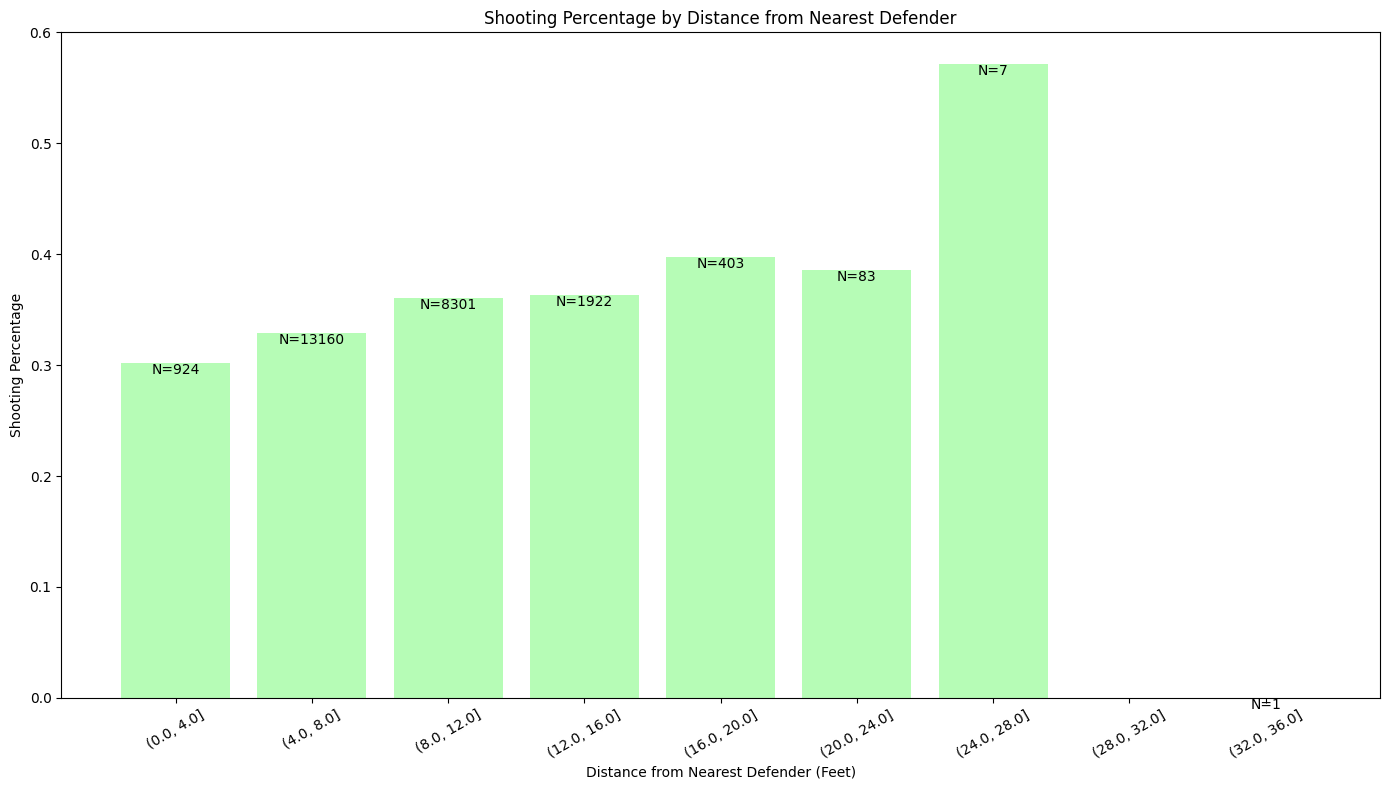

5547

In [40]:
# Create desired temporary df
tmp = pd.merge(loc_df[loc_df.set == "train"], pbp_df[pbp_df.set == "train"], on=["game_id", "play_id"])

# Create bins
bins = np.linspace(0, 40, 11)
tmp['dist_bin'] = pd.cut(tmp['1_closest_to_shooter_def_dist_to_shooter'], bins=bins)

# Obtain binned shooting percentagtes
tmp = tmp.groupby('dist_bin').agg(shooting_percentage=('Target', 'mean'), shot_count=('Target', 'size')).reset_index()

# Plot
plt.figure(figsize=(14, 8))
bars = plt.bar(tmp['dist_bin'].astype(str), tmp['shooting_percentage'], color='palegreen', alpha=0.7)

for bar, count in zip(bars, tmp['shot_count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'N={count}', 
             ha='center', va='top')


plt.xticks(rotation=30)
plt.xlabel('Distance from Nearest Defender (Feet)')
plt.ylabel('Shooting Percentage')
plt.title('Shooting Percentage by Distance from Nearest Defender')
plt.tight_layout()
plt.show()

# Garbage collection
del tmp
gc.collect()

**Shooting Percentage by Distance of Nearest Defender Analysis:**

*Observations*:

* To really no surprise here, our dataset shows that the more room you give a shooter, the better they will shoot. It's a lot easier when you don't have a hand in your face.
* There's a couple hundred entries where the shooter has 15+ feet of space! Which is a whole lot of freedom.
    * This may be interesting if players are coming down the floor from a fast break. Investigating things like speed may account for how well teams can guard the three out of the break.

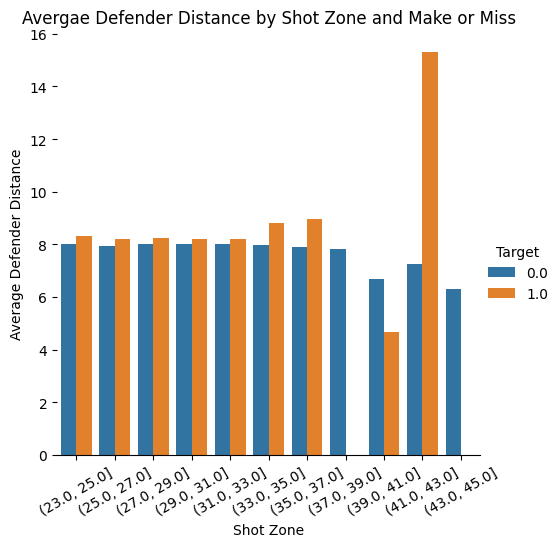

In [41]:
# Create desired temporary df
tmp = pd.merge(loc_df[loc_df.set == "train"], pbp_df[pbp_df.set == "train"], on=["game_id", "play_id"])

# Create bins
bins = np.linspace(23, 45, 12)
tmp['dist_bin'] = pd.cut(tmp['shooter_dist_to_basket'], bins=bins)

# Obtain binned shooting percentagtes
tmp = tmp.groupby(['dist_bin', 'Target']).agg(avg_defender_dist=("1_closest_to_shooter_def_dist_to_shooter", 'mean')).reset_index()

g = sns.catplot(x="dist_bin", y="avg_defender_dist", hue="Target", data=tmp, kind='bar')
g.despine(left=True)
g.set_axis_labels("Shot Zone", "Average Defender Distance")

plt.xticks(rotation=30)
plt.title("Avergae Defender Distance by Shot Zone and Make or Miss")
plt.show()

**Average Defender Distance by Shot Zone on Make or Miss Analysis:**

*Observations*:

* When grouped into less bins, it seems like defenders on average don't really change their approach with respect to the distance that they are from shooters. It is worth noting though that at almost every single distance, the average defender distance on makes is further away than on misses.

## Floor Spacing <a name="fs"></a>

Aside from distance to the nearest defender in regards to spacing, we want to know how spread out the offenses and defenses are in general. What was always taught to me growing up is if you space the floor on offense, it helps get guys open. At the same time, this may be a little bit more difficult to tell. If your point guard slashes and kicks, the offensive spacing may not be as great, but that's where analysis of the defensive spacing comes into play!

We will be using a technique called the **Delauney** approach.

This algorithm obtains the maximal surface area associated with data points, but all data points must be included.

In [42]:
def compute_area(points):
    if len(points) < 3:
        return np.nan

    # Create a Delaunay triangulation of the points
    tri = Delaunay(points)
    
    # Create the polygon and ensure it is oriented correctly
    polygon = Polygon(points)
    polygon = orient(polygon, sign=1.0)
    
    # Calculate area of each triangle and sum up
    area = 0.0
    for simplex in tri.simplices:
        triangle = Polygon([points[simplex[0]], points[simplex[1]], points[simplex[2]]])
        area += triangle.area
    
    return area

def process_group_poly(group_info):
    '''
    Function that takes grouping of players on each team and returns a dataframe of the spacing of each team via Shapely.
    
    Input(s):
        - group_info (Dict): The associated group info with your dataframe grouping. Ex: key: (game_id, play_id), value: (x, y)
    
    Returns:
        - results (list of Dicts): List of results including the game_id, play_id, frame, and the convex hull spacings of each team.
    '''
    (game_id, play_id), group = group_info
    # Extract the coordinates for team t1-t4 and the shooter
    t_points = group[(group['annotation_code'].str.startswith('t')) | (group['annotation_code'].str.startswith('s'))][['court_x', 'court_y']].values
    # Extract the coordinates for team d1-d5
    d_points = group[group['annotation_code'].str.startswith('d')][['court_x', 'court_y']].values
    
    # Calculate the area for t_points and d_points
    t_area = compute_area(t_points)
    d_area = compute_area(d_points)
    
    result = {
        'game_id': game_id,
        'play_id': play_id,
        't_area': t_area,
        'd_area': d_area
    }

    return result

In [43]:
# Create groupings for functions
tmp = loc_df2.groupby(['game_id', 'play_id'])

# Prepare data for processing
group_data = [(key, group) for key, group in tqdm(tmp, total=len(tmp), position=0, leave=True)]

# Process with tqdm and joblib to obtain convext hull of every play when the shot goes up
results = Parallel(n_jobs=-1)(
    delayed(process_group_poly)(group_info) for group_info in tqdm(group_data, total=len(group_data), position=0, leave=True)
)

# Convert results into DataFrame
area_df = pd.DataFrame(results)

# Merge with loc_df
loc_df2 = pd.merge(loc_df2, area_df, on=['game_id', 'play_id'], how='left')

# Garbage Collection
del area_df, tmp
gc.collect()

100%|██████████| 31341/31341 [00:53<00:00, 587.22it/s]


31

In [44]:
loc_df2 = loc_df2.groupby(["game_id", "play_id"]).first().reset_index()

# Merge these areas with our actual location df
loc_df = loc_df.merge(loc_df2[["game_id", "play_id", "t_area", "d_area"]], on=["game_id", "play_id"], how="left")

Here's a quick example of the first play in the dataset.

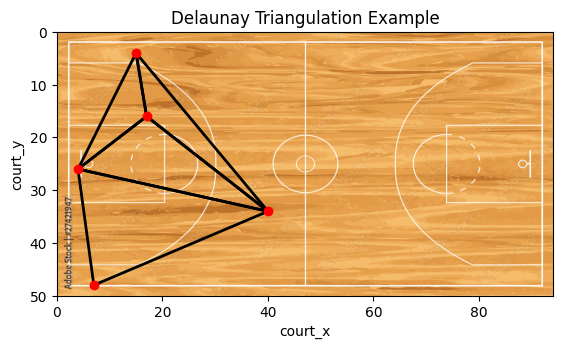

In [45]:
# Load image from the internet
url = "https://as2.ftcdn.net/v2/jpg/00/27/42/19/1000_F_27421947_OjxwPFPycRJSOaLSyHeXTr75GpsXAzeP.jpg"
img = Image.open(BytesIO(requests.get(url).content))

# Convert the image to an array
img_array = np.array(img)

# Extract points for example
points = np.array([[15, 17, 40, 4, 7], [4, 16, 34, 26, 48]]).T

# Perform Delaunay triangulation
tri = Delaunay(points)

# Plot
fig, ax = plt.subplots()
ax.imshow(img_array, extent=[0, 94, 50, 0])

# Plot points
ax.plot(points[:, 0], points[:, 1], 'o', color='red')

# Plot the Delaunay triangles
for simplex in tri.simplices:
    triangle = Polygon([points[simplex[0]], points[simplex[1]], points[simplex[2]]])
    triangle = orient(triangle, sign=1.0)
    patch = MPolygon(triangle.exterior.coords, closed=True, edgecolor='black', facecolor='none', linestyle='-', linewidth=2)
    ax.add_patch(patch)

# Plot settings
ax.set_xlabel('court_x')
ax.set_ylabel('court_y')
ax.set_title('Delaunay Triangulation Example')

plt.show()


This quick example demonstrates the triangles that are added up using Delauney polygons to get square footage of area spacing.

In [46]:
# Creation of spatial features with respect to the players contributing the spacing
loc_df["t_area_avg"] = loc_df["t_area"]/loc_df["offensive_count"]
loc_df["d_area_avg"] = loc_df["d_area"]/loc_df["defensive_count"]

# Create a ratio of spacing from offense to defense
loc_df['spacing_ratio'] = loc_df["t_area_avg"]/loc_df["d_area_avg"]

# Let's capture that ellipsoidal relationship in the graph.
loc_df['t_area_avg_sq'] = loc_df.apply(lambda row: (row['t_area'])**2, axis=1)
loc_df['d_area_avg_sq'] = loc_df.apply(lambda row: (row['d_area'])**2, axis=1)
loc_df['tareaavg_x_dareaavg'] = loc_df.apply(lambda row: (row['t_area'])*(row['d_area']), axis=1)

loc_df["diff_spacing"] = loc_df["t_area_avg"] - loc_df["d_area_avg"]

### Spacing Count within 12 Feet of Shooter

Get a count of how many players are within 12 feet of the shooter. Helps to see if the shooter is being doubled or other players near the shooter aren't a threat from the perimeter.

In [47]:
# Get defensive distances from shooter columns
cols = [col for col in loc_df.columns if col.endswith("closest_to_shooter_def_dist_to_shooter")]

# Apply
loc_df["count_within_12ft"] = loc_df[cols].apply(lambda row: (row <= 12).sum(), axis=1)

### Offensive vs Defensive Spacing on Shooting Percent <a name="ods"></a>

In [48]:
# Create tmp df
tmp = pd.merge(loc_df[(loc_df['set'] == "train") & (loc_df[['t_area_avg', 'd_area_avg']].notnull().all(axis=1))], pbp_df[pbp_df['set'] == "train"], how="left", on=["game_id", "play_id"])

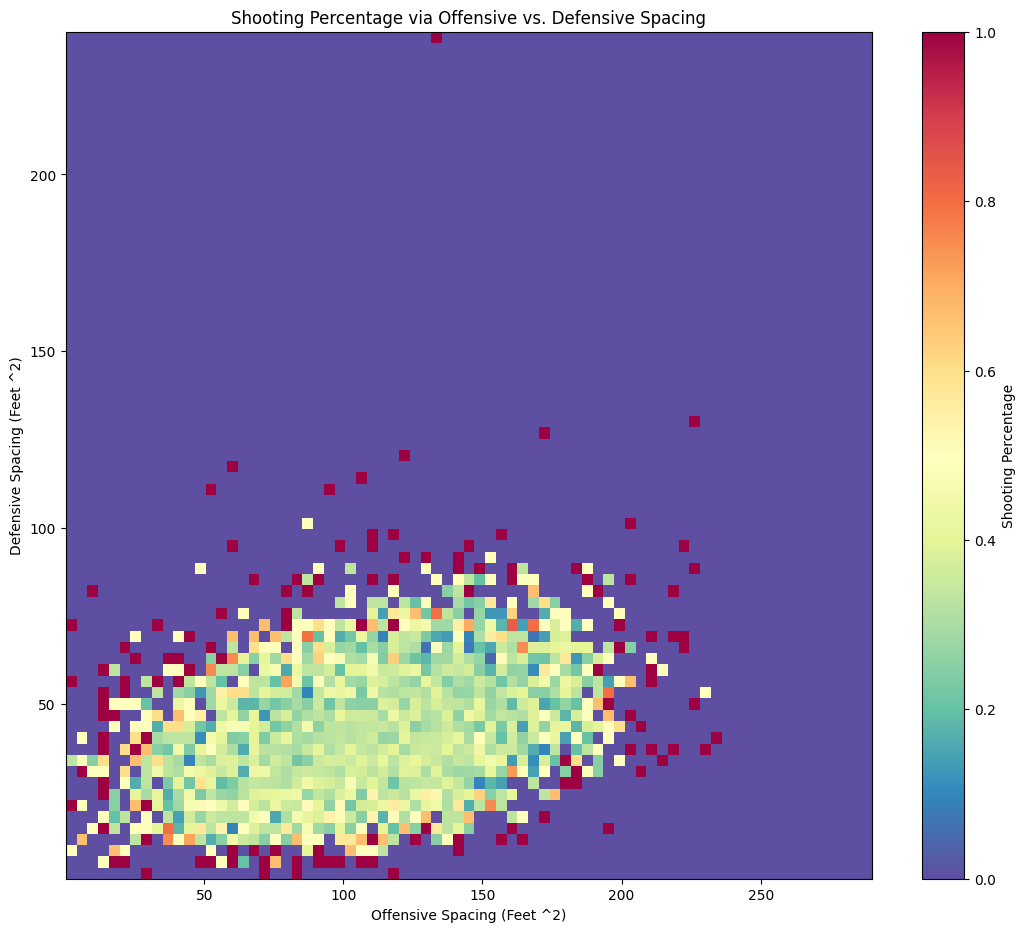

In [49]:
# Assign dimensions for 2d histogram
x = tmp['t_area_avg']
y = tmp['d_area_avg']
z = tmp['Target']

# 2 histogram of data created, weighted by the shooting percentage
hist, xedges, yedges = np.histogram2d(x, y, bins=[75, 75], weights=z)

# Normalize the histogram 
attempt_hist, _, _ = np.histogram2d(x, y, bins=[75, 75])
with np.errstate(divide='ignore', invalid='ignore'):
    hist = np.divide(hist, attempt_hist, where=attempt_hist != 0)

# Plot
plt.figure(figsize=(13, 11))
plt.imshow(hist.T, origin='lower', cmap="Spectral_r", aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Shooting Percentage')
plt.title('Shooting Percentage via Offensive vs. Defensive Spacing')
plt.xlabel('Offensive Spacing (Feet ^2)')
plt.ylabel('Defensive Spacing (Feet ^2)')
plt.show()

**Shooting Percentage vs. Offensive Spacing vs. Defensive Spacing Analysis:**

*Observations*:

* When the defense gets very condensed or spaced out, the offense has a higher percentage chance of making the shot.
* The offense also seems to do better when they are more extremely spaced out or condensed.
* Formation of an ellipsoidal relationship between these two features.

## Defensive Density w/ Respect to the Shooter <a name="density"></a>

Let's create a ratio of the general defensive density of all players vs. the defensive density of those closest to the shooter.

To calculate this, we need to include some density formula that will account for density in general. I believe that density should take into account the distances from the shooter as well as the angle positioning of the defenders. 

As the defender's distance from the shooter becomes larger, the less we should care about the density of players with respect to the shooter. We don't care as much about a big on the opposite side of the floor as we do the perimeter obligation for a defense when it comes to shooting threes. Thus, we will have to create a metric that reduces the density value as the distance away from the shooter gets larger. Here we will rely on exponentiation.

The defensive density is calculated using the following formula:

$$
\text{density} = \sum_{{i=1}}^{n} \left( 0.83^{\text{dist}_{\text{shooter}, i}} \times 1.01^{\text{angle}_{\text{shooter}, i}} \right)
$$

where:
* $\text{dist}_{\text{shooter}, i}$ is the Euclidean distance of the \(i\)-th player to the shooter.
* $\text{angle}_{\text{shooter}, i}$ is the angle formed at the basket between the \(i\)-th player and the shooter.
* The constants $0.83$ and $1.01$ are decay factors for distance and angle, respectively, found from testing coefficients.


In [50]:
def calculate_close_defensive_density(distances_to_shooter, angles_with_shooter):
    ''' 
    Calculates the defensive density of players within a specific threshold of the shooter.
    
    Inputs:
        - distances_to_shooter (List): List of player euclidian distances to the shooter.
        - angles_with_shooter (List): List of angles formed at the basket between the player and the shooter. 
    Returns:
        - density (float): Density calculated.
    '''
    density = 0
    
    for dist_shooter, angle_shooter in zip(distances_to_shooter, angles_with_shooter):
        dist_factor = 0.83**dist_shooter
        angle_factor = 1.01**angle_shooter
        density += dist_factor * angle_factor
    
    return density
    

In [51]:
# Obtain cols
dist_shooter_cols = [col for col in loc_df.columns if col.endswith("closest_to_shooter_def_dist_to_shooter")]
ang_shooter_cols = [col for col in loc_df.columns if col.endswith("closest_to_shooter_def_rel_angle_to_shooter")]

# Create density measure
loc_df["def_density"] = loc_df.apply(lambda row: calculate_close_defensive_density(row[dist_shooter_cols].values.tolist(), row[ang_shooter_cols].values.tolist()), axis=1)

Let's make anoter featured called `d_ratio` which will give some insight as to what relativity of our spacing ratio is contributed to by the defensive density relative to the shooter.

In [52]:
loc_df["d_ratio"] = loc_df["spacing_ratio"] / loc_df["def_density"]

Our last feature in this area will connect the defensive density relative to the shooter and the shooter's distance to the basket. If a shooter is further from the basket and commands a large defensive density, that means they are probably more of a threat.

In [53]:
loc_df["density_via_distance"] = loc_df["shooter_dist_to_basket"] * loc_df["def_density"]

## Player Distances and Speed over Time <a name="speed"></a>

How much are players moving around? Is the shooter trying to get to an open part of the floor? Is the defensive matching the movements of the offensive players? Let's finally meddle with our tracking data.

In [54]:
# Shift coordinates to get previous frame's coordinates
track_df[['prev_x', 'prev_y']] = track_df.groupby(['game_id', 'play_id', 'type', 'tracklet_id'])[['x', 'y']].shift()

# Calculate Euclidean distance between consecutive frames
track_df['dist_trav_from_last'] = np.sqrt((track_df['x'] - track_df['prev_x'])**2 + (track_df['y'] - track_df['prev_y'])**2)

# For the std deviation and average of distance traveled per frame (speed)
dist_tmp = track_df.groupby(['game_id', 'play_id', 'type']).agg(
    top_speed_ = ('dist_trav_from_last', 'max'),
    avg_speed_=('dist_trav_from_last', 'mean'),
    std_speed_=('dist_trav_from_last', 'std')).reset_index()
     
# Summarize each tracklet to get a sum of how far each player traveled
dist_trav = track_df.groupby(['game_id', 'play_id', 'type', 'tracklet_id']).agg(
    player_dist=('dist_trav_from_last', 'sum'),
    frame_count=('dist_trav_from_last', 'size')).reset_index()

# Obtain average distance of each class
dist_trav = dist_trav.groupby(['game_id', 'play_id', 'type']).agg(
    avg_dist_=('player_dist', 'mean')).reset_index()

# Merge features
dist_trav = dist_trav.merge(dist_tmp[["game_id", "play_id", "type", "std_speed_", "avg_speed_", "top_speed_"]], on=["game_id", "play_id", "type"], how="left")

# Pivot the table to get distances and speeds for each player type in one DataFrame
dist_pivot = dist_trav.pivot_table(index=['game_id', 'play_id'], columns='type', values=['avg_dist_', 'avg_speed_', 'std_speed_', 'top_speed_'], fill_value=0).reset_index()

# Modify columns for each category
dist_pivot.columns = [''.join(col).strip() for col in dist_pivot.columns.values]

In [55]:
df = loc_df.merge(dist_pivot, on=["game_id", "play_id"], how="left")

In [56]:
# Merge feature data with target data
df = df.merge(pbp_df, on=["game_id", "play_id", "set"], how="left")

In [57]:
pd.set_option("display.max_columns", None)
df.head(3)

,game_id,play_id,basket,defensive_count,offensive_count,set,shooter_dist_to_basket,shooter_rel_bask_angle,shot_r_side,1_closest_to_shooter_off,1_closest_to_shooter_off_side,1_closest_to_shooter_off_half,1_closest_to_shooter_off_x_y,1_closest_to_shooter_off_dist_to_basket,1_closest_to_shooter_off_rel_bask_angle,1_closest_to_shooter_off_dist_to_shooter,1_closest_to_shooter_off_rel_angle_to_shooter,1_closest_to_shooter_off_closest_opposing_player,1_closest_to_shooter_off_dist_to_closest_opposing,1_closest_to_shooter_off_rel_angle_to_closest_opposing,2_closest_to_shooter_off,2_closest_to_shooter_off_side,2_closest_to_shooter_off_half,2_closest_to_shooter_off_x_y,2_closest_to_shooter_off_dist_to_basket,2_closest_to_shooter_off_rel_bask_angle,2_closest_to_shooter_off_dist_to_shooter,2_closest_to_shooter_off_rel_angle_to_shooter,2_closest_to_shooter_off_closest_opposing_player,2_closest_to_shooter_off_dist_to_closest_opposing,2_closest_to_shooter_off_rel_angle_to_closest_opposing,3_closest_to_shooter_off,3_closest_to_shooter_off_side,3_closest_to_shooter_off_half,3_closest_to_shooter_off_x_y,3_closest_to_shooter_off_dist_to_basket,3_closest_to_shooter_off_rel_bask_angle,3_closest_to_shooter_off_dist_to_shooter,3_closest_to_shooter_off_rel_angle_to_shooter,3_closest_to_shooter_off_closest_opposing_player,3_closest_to_shooter_off_dist_to_closest_opposing,3_closest_to_shooter_off_rel_angle_to_closest_opposing,4_closest_to_shooter_off,4_closest_to_shooter_off_side,4_closest_to_shooter_off_half,4_closest_to_shooter_off_x_y,4_closest_to_shooter_off_dist_to_basket,4_closest_to_shooter_off_rel_bask_angle,4_closest_to_shooter_off_dist_to_shooter,4_closest_to_shooter_off_rel_angle_to_shooter,4_closest_to_shooter_off_closest_opposing_player,4_closest_to_shooter_off_dist_to_closest_opposing,4_closest_to_shooter_off_rel_angle_to_closest_opposing,1_closest_to_shooter_def,1_closest_to_shooter_def_side,1_closest_to_shooter_def_half,1_closest_to_shooter_def_x_y,1_closest_to_shooter_def_dist_to_basket,1_closest_to_shooter_def_rel_bask_angle,1_closest_to_shooter_def_dist_to_shooter,1_closest_to_shooter_def_rel_angle_to_shooter,1_closest_to_shooter_def_closest_opposing_player,1_closest_to_shooter_def_dist_to_closest_opposing,1_closest_to_shooter_def_rel_angle_to_closest_opposing,2_closest_to_shooter_def,2_closest_to_shooter_def_side,2_closest_to_shooter_def_half,2_closest_to_shooter_def_x_y,2_closest_to_shooter_def_dist_to_basket,2_closest_to_shooter_def_rel_bask_angle,2_closest_to_shooter_def_dist_to_shooter,2_closest_to_shooter_def_rel_angle_to_shooter,2_closest_to_shooter_def_closest_opposing_player,2_closest_to_shooter_def_dist_to_closest_opposing,2_closest_to_shooter_def_rel_angle_to_closest_opposing,3_closest_to_shooter_def,3_closest_to_shooter_def_side,3_closest_to_shooter_def_half,3_closest_to_shooter_def_x_y,3_closest_to_shooter_def_dist_to_basket,3_closest_to_shooter_def_rel_bask_angle,3_closest_to_shooter_def_dist_to_shooter,3_closest_to_shooter_def_rel_angle_to_shooter,3_closest_to_shooter_def_closest_opposing_player,3_closest_to_shooter_def_dist_to_closest_opposing,3_closest_to_shooter_def_rel_angle_to_closest_opposing,4_closest_to_shooter_def,4_closest_to_shooter_def_side,4_closest_to_shooter_def_half,4_closest_to_shooter_def_x_y,4_closest_to_shooter_def_dist_to_basket,4_closest_to_shooter_def_rel_bask_angle,4_closest_to_shooter_def_dist_to_shooter,4_closest_to_shooter_def_rel_angle_to_shooter,4_closest_to_shooter_def_closest_opposing_player,4_closest_to_shooter_def_dist_to_closest_opposing,4_closest_to_shooter_def_rel_angle_to_closest_opposing,5_closest_to_shooter_def,5_closest_to_shooter_def_side,5_closest_to_shooter_def_half,5_closest_to_shooter_def_x_y,5_closest_to_shooter_def_dist_to_basket,5_closest_to_shooter_def_rel_bask_angle,5_closest_to_shooter_def_dist_to_shooter,5_closest_to_shooter_def_rel_angle_to_shooter,5_closest_to_shooter_def_closest_opposing_player,5_closest_to_shooter_def_dist_to_closest_opposing,5_closest_to_shooter_d

In [58]:
df.fillna(-1, inplace=True)
df.drop(columns=["Unnamed: 0"], inplace=True)

***

# Modeling <a name="model"></a>

In [59]:
# Split our data into training and testing sets.
training_set = df[df.set == "train"]
testing_set = df[df.set == "test"]

In [60]:
testing_set['ID'] = testing_set['game_id'].astype(int).astype(str) + '-' + testing_set['play_id'].astype(int).astype(str)
testing_ids = testing_set['ID'].tolist()

Let's create a function that allows us to make submissions easily -- I have a feeling we are going to make quite a few.

In [61]:
def create_submission(testing_ids, predicitons, unique_csv_tag):
    
    # Create submission dataframe
    sub_df = pd.DataFrame({'ID': testing_ids, 
                      'Target': predictions.flatten()})
   
    
    sub_df.to_csv(f"submission_{unique_csv_tag}.csv", index=False)

In [62]:
X_train = training_set.select_dtypes(include=[np.number])
X_train = X_train.loc[:, ~X_train.columns.isin(["game_id", "play_id", "Target"])]

X_test = testing_set.select_dtypes(include=[np.number])
X_test = X_test.loc[:, ~X_test.columns.isin(["game_id", "play_id", "Target"])]

y = training_set["Target"]

In [63]:
# Scale features
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y = y.to_numpy()

## New Baselines Using All Features

Here we are going to use all of the future we have accumulated and deploy them as the input for three separate models 

* Logistic Regression
* XGBoost
* Random Forest

#### Logistic Regression

In [64]:
if RUN_CELL:
    pipeline = Pipeline([
        ('lr', LogisticRegression(random_state=821, warm_start=True))
    ])

    param_grid = {
        'lr__solver': ['lbfgs', 'liblinear', 'saga'],
        'lr__penalty': ['l1', 'l2'],
        'lr__C': [0.05, 0.1, 0.3]
    }

    grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
    grid_search_lr.fit(X_train, y)

    best_params_lr = grid_search_lr.best_params_
    best_roc_lr = grid_search_lr.best_score_

    print(best_params_lr)
    print(best_roc_lr)

In [65]:
if RUN_CELL:
    # Create CV Folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

    # Instantiate model: parameters found from previous grid search.
    model = LogisticRegression(solver='liblinear', random_state=821, penalty="l1", C=0.05, warm_start=True)
    cv_scores = []
    tr_scores=[]
    sub_preds = []

    for t_idx, v_idx in skf.split(X, y):
        X_tr, X_te = X[t_idx], X[v_idx]
        y_tr, y_te = y[t_idx], y[v_idx]

        # Fit model
        model.fit(X_tr, y_tr)

        # Training roc_aucs to check for overfitting
        y_pred = model.predict_proba(X_tr)[:,1]
        score = roc_auc_score(y_tr, y_pred)
        tr_scores.append(score)

        # CV roc_aucs
        y_pred = model.predict_proba(X_te)[:,1]
        score = roc_auc_score(y_te, y_pred)
        cv_scores.append(score)

        # Append submissions
        sub_pred = model.predict_proba(X_test)[:,1]
        sub_preds.append(sub_pred)

    print(tr_scores)
    print(cv_scores)
    print(np.mean(cv_scores))
    print(np.mean(sub_preds))

#### Random Forest

In [66]:
if RUN_CELL:
    pipeline = Pipeline([
        ('rf', RandomForestClassifier(random_state=821, warm_start=True, n_estimators=100))
    ])

    param_grid = {
        'rf__min_samples_split': [1, 2],
        'rf__min_samples_leaf': [4, 6, 8],
        'rf__max_depth': [4, 5]
    }

    grid_search_rf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
    grid_search_rf.fit(X_train, y)

    best_params_rf = grid_search_rf.best_params_
    best_roc_rf = grid_search_rf.best_score_

    print(best_params_rf)
    print(best_roc_rf)

In [67]:
if RUN_CELL:
    # Create CV Folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

    # Instantiate model
    model = RandomForestClassifier(random_state=821, min_samples_leaf=6, n_estimators=100, min_samples_split=2, max_depth=4)
    cv_scores = []
    tr_scores=[]
    sub_preds = []

    for t_idx, v_idx in skf.split(X, y):
        X_tr, X_te = X[t_idx], X[v_idx]
        y_tr, y_te = y[t_idx], y[v_idx]

        # Fit model
        model.fit(X_tr, y_tr)

        # Training roc_aucs to check for overfitting
        y_pred = model.predict_proba(X_tr)[:,1]
        score = roc_auc_score(y_tr, y_pred)
        tr_scores.append(score)

        # CV roc_aucs
        y_pred = model.predict_proba(X_te)[:,1]
        score = roc_auc_score(y_te, y_pred)
        cv_scores.append(score)

        # Append submissions
        sub_pred = model.predict_proba(X_test)[:,1]
        sub_preds.append(sub_pred)

    print(tr_scores)
    print(cv_scores)
    print(np.mean(cv_scores))
    print(np.mean(sub_preds))

In [68]:
if RUN_CELL:
    rf_importances = pd.DataFrame({
        'cols': X_train.columns,
        'importance': model.feature_importances_
    })

    rf_importances.sort_values(by="importance", ascending=False)
    rf_features = rf_importances[rf_importances.importance > 0.015]

Here our cross-validation set does worse than our initial baseline set. At the same time, however, our training set is able to get 0.9999 for all of the training folds. This means with the random fit and our features, we are experiencing some overfitting.

#### XGBoost

In [69]:
if RUN_CELL:
    pipeline = Pipeline([
        ('xgb', xgb.XGBClassifier(random_state=821, n_estimators=100))
    ])

    param_grid = {
        'xgb__max_depth': [2, 3],
        'xgb__min_child_weight': [11, 13, 15],
        'xgb__learning_rate': [0.0075, 0.01]
    }

    grid_search_xgb = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
    grid_search_xgb.fit(X_train, y)

    best_params_xgb = grid_search_xgb.best_params_
    best_roc_xgb = grid_search_xgb.best_score_

    print(best_params_xgb)
    print(best_roc_xgb)

In [70]:
if RUN_CELL:
    # Create CV Folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

    # Instantiate model
    model = xgb.XGBClassifier(random_state=821, n_estimators=100, learning_rate=0.01, min_child_weight=9, max_depth=5)
    cv_scores = []
    tr_scores=[]
    sub_preds = []

    smote = SMOTE(random_state=821)

    for t_idx, v_idx in skf.split(X, y):
        X_tr, X_te = X[t_idx], X[v_idx]
        y_tr, y_te = y[t_idx], y[v_idx]

        # Fit model
        model.fit(X_tr, y_tr)

        # Training roc_aucs to check for overfitting
        y_pred = model.predict_proba(X_tr)[:,1]
        score = roc_auc_score(y_tr, y_pred)
        tr_scores.append(score)

        # CV roc_aucs
        y_pred = model.predict_proba(X_te)[:,1]
        score = roc_auc_score(y_te, y_pred)
        cv_scores.append(score)

        # Append submissions
        sub_pred = model.predict_proba(X_test)[:,1]
        sub_preds.append(sub_pred)

    print(tr_scores)
    print(cv_scores)
    print(np.mean(cv_scores))
    print(np.mean(sub_preds))

In [71]:
if RUN_CELL:
    xgb_importances = pd.DataFrame({
        'cols': X_train.columns,
        'importance': model.feature_importances_
    })

    xgb_importances.sort_values(by="importance", ascending=False)
    xgb_features = xgb_importances[xgb_importances.importance > 0.012]

Once again, we aren't scraping by our baseline model although our training set is able to have a reliably high ROC AUC. We should probably reduce some features.

As mentioned, some of our training ROC AUCS perform extremely well; however, this data isn't generalized to the cross-validation sets similarly. This indicates that these baseline models are significantly struggling with overfitting. To correct for overfitting, there are three methods we can employ:

* More training examples
* Feature reduction
* Regularization

Because our training examples are very limited to what we have in the given dataset and we did employ some regularization, our next steps will involve finding out which features are relevant to our models.

## Feature Selection and Tuning

### Recursive Feature Elimination w/ Cross-Validation:
Selecting features by fitting an RFE selector on different cross-validation splits. The scores are averaged across folds and the number of features selected is set to the number of features that maximize our CV score.

In [72]:
if RUN_CELL:
    model = LogisticRegression(solver='liblinear', random_state=821, penalty="l1", C=0.05, warm_start=True)
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    pipeline.fit(X_train, y)

In [73]:
if RUN_CELL:
    features = training_set.select_dtypes(include=[np.number])
    features = features.loc[:, ~features.columns.isin(["game_id", "play_id", "Target"])]
    features.columns[rfecv.support_]

#### Logistic Regression

In [74]:
lr_features = ['shooter_rel_bask_angle',
       '2_closest_to_shooter_off_rel_angle_to_shooter',
       '3_closest_to_shooter_off_rel_angle_to_shooter',
       '1_closest_to_shooter_def_dist_to_shooter',
       '2_closest_to_shooter_def_dist_to_basket',
       '2_closest_to_shooter_def_rel_bask_angle',
       '5_closest_to_shooter_def_half', 't_area_avg', 'tareaavg_x_dareaavg',
       'density_via_distance']

X_train = training_set.loc[:, training_set.columns.isin(lr_features)].to_numpy()
X_test = testing_set.loc[:, testing_set.columns.isin(lr_features)].to_numpy()

y = training_set["Target"].to_numpy()

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [75]:
if RUN_CELL:
    pipeline = Pipeline([
        ('lr', LogisticRegression(random_state=821, warm_start=True))
    ])

    param_grid = {
        'lr__solver': ['lbfgs', 'liblinear', 'saga'],
        'lr__penalty': ['l1', 'l2'],
        'lr__C': [0.05, 0.1, 0.3]
    }

    grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)
    grid_search_lr.fit(X_train, y)

    best_params_lr = grid_search_lr.best_params_
    best_roc_lr = grid_search_lr.best_score_

    print(best_params_lr)
    print(best_roc_lr)

Our best params here involve
* C: 0.1
* penalty: l2
* solver: lbfgs

With a best ROC of 0.5392854394486474

In [76]:
# Create CV Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

# Instantiate model: parameters found from previous grid search.
model = LogisticRegression(solver='lbfgs', random_state=821, penalty="l2", C=0.1, warm_start=True)
cv_scores = []
tr_scores=[]
tr_preds_lr=[]
te_preds_lr=[]
sub_preds_lr = []

for t_idx, v_idx in skf.split(X_train, y):
    X_tr, X_te = X_train[t_idx], X_train[v_idx]
    y_tr, y_te = y[t_idx], y[v_idx]
    
    # Fit model
    model.fit(X_tr, y_tr)
    
    # Training roc_aucs to check for overfitting
    y_pred = model.predict_proba(X_tr)[:,1]
    tr_preds_lr.append(y_pred)
    score = roc_auc_score(y_tr, y_pred)
    tr_scores.append(score)
    
    # CV roc_aucs
    y_pred = model.predict_proba(X_te)[:,1]
    te_preds_lr.append(y_pred)
    score = roc_auc_score(y_te, y_pred)
    cv_scores.append(score)
    
    # Append submissions
    sub_pred = model.predict_proba(X_test)[:,1]
    sub_preds_lr.append(sub_pred)
    
print(tr_scores)
print(cv_scores)
print(np.mean(cv_scores))
print(np.mean(sub_preds_lr))

[0.546286515842261, 0.5402127902644153, 0.5413705413248695, 0.542158750732513, 0.5424378054027347]
[0.5240341504256061, 0.5460012809152651, 0.5446583084796937, 0.5407242787598303, 0.5376261917966567]
0.5386088420754104
0.34312397463411903


In [77]:
predictions = np.mean(sub_preds_lr, axis=0)

create_submission(testing_ids, predictions, "lr_frs")

#### XGBoost

We have features from personal testing with xgb that we are going to deploy.

In [78]:
xgb_features = ['shooter_dist_to_basket', 'shooter_rel_bask_angle', 
            '1_closest_to_shooter_off_dist_to_shooter',
            '1_closest_to_shooter_off_rel_angle_to_shooter',
            '1_closest_to_shooter_off_dist_to_basket',
            '2_closest_to_shooter_off_dist_to_shooter',
            '2_closest_to_shooter_off_dist_to_basket',
            '2_closest_to_shooter_off_rel_angle_to_shooter',
            '1_closest_to_shooter_def_dist_to_basket',
            '1_closest_to_shooter_def_dist_to_shooter',
            '1_closest_to_shooter_def_rel_angle_to_shooter',
            '1_closest_to_shooter_def_rel_bask_angle',
            '2_closest_to_shooter_def_dist_to_basket',
            '2_closest_to_shooter_def_dist_to_shooter',
            '2_closest_to_shooter_def_rel_angle_to_shooter',
            '2_closest_to_shooter_def_rel_bask_angle',
            'top_speed_defender', 
            'd_area_avg', 't_area_avg_sq', 'd_area_avg_sq', 'tareaavg_x_dareaavg', 'count_within_12ft', 'd_ratio', 'def_density', 'density_via_distance']

X_train = training_set.loc[:, training_set.columns.isin(xgb_features)].to_numpy()
X_test = testing_set.loc[:, testing_set.columns.isin(xgb_features)].to_numpy()

y = training_set["Target"].to_numpy()

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
if RUN_CELL:
    pipeline = Pipeline([
        ('xgb', xgb.XGBClassifier(random_state=821))
    ])

    param_grid = {
        'xgb__n_estimators': [100, 125],
        'xgb__max_depth': [2, 3, 4],
        'xgb__min_child_weight': [12, 13, 14],
        'xgb__learning_rate': [0.001, 0.01, 0.1]
    }

    grid_search_xgb = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
    grid_search_xgb.fit(X_train, y)

    best_params_xgb = grid_search_xgb.best_params_
    best_roc_xgb = grid_search_xgb.best_score_

    print(best_params_xgb)
    print(best_roc_xgb)

Our best params here are
* learning_rate: 0.1
* max_depth: 2
* min_child_weight: 12
* n_estimators: 125

With a top ROC of 0.5381980376465743



In [80]:
# Create CV Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

# Instantiate model: parameters found from previous grid search.
model = xgb.XGBClassifier(random_state=821, learning_rate=0.01, max_depth=3, min_child_weight=13, n_estimators=100)
cv_scores = []
tr_scores=[]
tr_preds_xgb=[]
te_preds_xgb=[]
sub_preds_xgb = []

for t_idx, v_idx in skf.split(X_train, y):
    X_tr, X_te = X_train[t_idx], X_train[v_idx]
    y_tr, y_te = y[t_idx], y[v_idx]
    
    # Fit model
    model.fit(X_tr, y_tr)
    
    # Training roc_aucs to check for overfitting
    y_pred = model.predict_proba(X_tr)[:,1]
    tr_preds_xgb.append(y_pred)
    score = roc_auc_score(y_tr, y_pred)
    tr_scores.append(score)
    
    # CV roc_aucs
    y_pred = model.predict_proba(X_te)[:,1]
    te_preds_xgb.append(y_pred)
    score = roc_auc_score(y_te, y_pred)
    cv_scores.append(score)
    
    # Append submissions
    sub_pred = model.predict_proba(X_test)[:,1]
    sub_preds_xgb.append(sub_pred)
    
print(tr_scores)
print(cv_scores)
print(np.mean(cv_scores))
print(np.mean(sub_preds_xgb))

[0.5703018138595545, 0.5639598474070906, 0.5637947476204422, 0.5721571941597212, 0.5667349441962569]
[0.5236384435269094, 0.5359680050797723, 0.5436508863756737, 0.5350890753124117, 0.5440940857987349]
0.5364880992187004
0.3448972


In [81]:
predictions = np.mean(sub_preds_xgb, axis=0)

create_submission(testing_ids, predictions, "xgb_frs")

#### Random Forest

In [82]:
rf_features = [
    'shooter_rel_bask_angle',
    '3_closest_to_shooter_off_rel_angle_to_shooter',
    '1_closest_to_shooter_def_dist_to_basket',
    '1_closest_to_shooter_def_dist_to_shooter',
    '1_closest_to_shooter_def_rel_angle_to_shooter',
    '2_closest_to_shooter_def_dist_to_basket',
    '2_closest_to_shooter_def_dist_to_shooter',
    '3_closest_to_shooter_def_dist_to_shooter',
    '4_closest_to_shooter_def_dist_to_shooter',
    'std_angle_to_shooter_def',
    'd_area',
    't_area_avg',
    'd_area_avg',
    'def_density',
    'd_ratio',
    'density_via_distance'
]

X_train = training_set.loc[:, training_set.columns.isin(rf_features)].to_numpy()
X_test = testing_set.loc[:, testing_set.columns.isin(rf_features)].to_numpy()

y = training_set["Target"].to_numpy()

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
if RUN_CELL:
    pipeline = Pipeline([
        ('rf', RandomForestClassifier(random_state=821, warm_start=True))
    ])

    param_grid = {
        'rf__n_estimators': [275, 300],
        'rf__min_samples_split': [17, 18, 19],
        'rf__min_samples_leaf': [4, 5],
        'rf__max_depth': [4, 5, 6]
    }

    grid_search_rf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
    grid_search_rf.fit(X_train, y)

    best_params_rf = grid_search_rf.best_params_
    best_roc_rf = grid_search_rf.best_score_

    print(best_params_rf)
    print(best_roc_rf)

* max_depth = 5
* min_samples_leaf = 5
* min_samples_split = 17
* n_estimators = 300
* SCORE 0.5358248143863436

In [84]:
# Create CV Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=821)

# Instantiate model: parameters found from previous grid search.
model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=17, n_estimators=300, warm_start=True, random_state=821)
cv_scores = []
tr_scores=[]
tr_preds_rf=[]
te_preds_rf=[]
tr_y=[]
te_y=[]
sub_preds_rf = []

for t_idx, v_idx in skf.split(X_train, y):
    X_tr, X_te = X_train[t_idx], X_train[v_idx]
    y_tr, y_te = y[t_idx], y[v_idx]
    
    # Fit model
    model.fit(X_tr, y_tr)
    
    # Training roc_aucs to check for overfitting
    y_pred = model.predict_proba(X_tr)[:,1]
    tr_preds_rf.append(y_pred)
    tr_y.append(y_tr)
    score = roc_auc_score(y_tr, y_pred)
    tr_scores.append(score)
    
    # CV roc_aucs
    y_pred = model.predict_proba(X_te)[:,1]
    te_preds_rf.append(y_pred)
    te_y.append(y_te)
    score = roc_auc_score(y_te, y_pred)
    cv_scores.append(score)
    
    # Append submissions
    sub_pred = model.predict_proba(X_test)[:,1]
    sub_preds_rf.append(sub_pred)
    
print(tr_scores)
print(cv_scores)
print(np.mean(cv_scores))
print(np.mean(sub_preds_rf))

[0.6084113093132184, 0.5881169004862647, 0.5844548589693241, 0.588185966528264, 0.587987202028877]
[0.5232535318521931, 0.6048018925974317, 0.6196375263052055, 0.6044138177228423, 0.6050743037980959]
0.5914362144551537
0.34316887464311036


In [85]:
predictions = np.mean(sub_preds_rf, axis=0)

create_submission(testing_ids, predictions, "rf_frs")

## Ensemble Modeling with Different Models and Features

Let's combine these three models with their individualized featuring using a stacking classifier. The stacking classifier will take the three individual models I have created, the logistic regression, the random forest, and the xgboost models, and create a set of predictions for all three. These outputs will then be used as inputs for another model to make final predictions. Our model will flow as such:

**Base Models:**

`LogisticRegression(solver='lbfgs', random_state=821, penalty="l2", C=0.1, warm_start=True)`

`xgb.XGBClassifier(random_state=821, learning_rate=0.01, max_depth=3, min_child_weight=13, n_estimators=100)`

`RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=17, n_estimators=300, warm_start=True, random_state=821)`

**Final Model:**

`LogisticRegression(random_state=922)`

In [86]:
# Re-instantiate X and Y
X_train = training_set.select_dtypes(include=[np.number])

X_test = testing_set.select_dtypes(include=[np.number])
X_test = X_test.loc[:, ~X_test.columns.isin(["game_id", "play_id", "Target"])]

y = training_set["Target"].to_numpy()

# Instantiate Scaler
scaler = MinMaxScaler()

In [87]:
# ColumnTransformers for selecting features
lr_transformer = ColumnTransformer([('lr_features', 'passthrough', lr_features)], remainder='drop')
xgb_transformer = ColumnTransformer([('xgb_features', 'passthrough', xgb_features)], remainder='drop')
rf_transformer = ColumnTransformer([('rf_features', 'passthrough', rf_features)], remainder='drop')

# Pipelines for each model
lr_pipeline = Pipeline([
    ('select', lr_transformer),
    ('scale', scaler),
    ('lr', LogisticRegression(solver='lbfgs', random_state=821, penalty="l2", C=0.1, warm_start=True))
])

xgb_pipeline = Pipeline([
    ('select', xgb_transformer),
    ('scale', scaler),  
    ('xgb', xgb.XGBClassifier(random_state=821, learning_rate=0.01, max_depth=3, min_child_weight=13, n_estimators=100))
])

rf_pipeline = Pipeline([
    ('select', rf_transformer),
    ('scale', scaler),
    ('rf', RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=17, n_estimators=300, warm_start=True, random_state=821))
])

# Stacking model
stacked_model = StackingClassifier(
    estimators=[
        ('lr', lr_pipeline),
        ('xgb', xgb_pipeline),
        ('rf', rf_pipeline)
    ],
    final_estimator=LogisticRegression(max_iter=250),
    stack_method='predict_proba'
)

In [88]:
# Create CV Folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=922)
cv_scores = []
tr_scores = []
sub_preds_ensemble = np.zeros((X_test.shape[0], 3))  # Initialize for averaging test predictions
te_preds_ensemble = []
tr_preds_ensemble = []

for fold, (t_idx, v_idx) in enumerate(skf.split(X_train, y)):
    X_tr, X_te = X_train.iloc[t_idx], X_train.iloc[v_idx]
    y_tr, y_te = y[t_idx], y[v_idx]
    
    # Fit model
    stacked_model.fit(X_tr, y_tr)
    
    # Training roc_aucs to check for overfitting
    y_pred_train = stacked_model.predict_proba(X_tr)[:, 1]
    tr_preds_ensemble.append(y_pred_train)
    tr_score = roc_auc_score(y_tr, y_pred_train)
    tr_scores.append(tr_score)
    
    # Validation roc_aucs
    y_pred_valid = stacked_model.predict_proba(X_te)[:, 1]
    te_preds_ensemble.append(y_pred_valid)
    te_score = roc_auc_score(y_te, y_pred_valid)
    cv_scores.append(te_score)
    
    # Accumulate test set predictions for each fold
    sub_pred = stacked_model.predict_proba(X_test)[:, 1]
    sub_preds_ensemble[:, fold] = sub_pred
    
final_sub_preds = np.mean(sub_preds_ensemble, axis=1)

print(f'Training ROC AUC scores per fold: {tr_scores}')
print(f'Validation ROC AUC scores per fold: {cv_scores}')
print(f'Mean Validation ROC AUC: {np.mean(cv_scores)}')
print(f'Mean Prediction for submission: {np.mean(final_sub_preds)}')

Training ROC AUC scores per fold: [0.5799986253505154, 0.5690890976323129, 0.5695301953119897]
Validation ROC AUC scores per fold: [0.5371220866415571, 0.5383571285419196, 0.5314132413339486]
Mean Validation ROC AUC: 0.5356308188391418
Mean Prediction for submission: 0.34313410117746496


In [89]:
sub_df = pd.DataFrame({'ID': testing_ids, 
                  'Target': final_sub_preds.tolist()})


sub_df.to_csv(f"submission_ensemble.csv", index=False)

### Artificial Neural Network

In [90]:
desired = list(set(lr_features) | set(xgb_features) | set(rf_features))

# Create training data
copy = training_set.copy()
X_train = copy.loc[:, copy.columns.isin(desired)]
X_test = testing_set.loc[:, testing_set.columns.isin(desired)]
y = copy["Target"].to_numpy()

# Scale features
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Let's instantiate our model**
We are going to start with an artificial neural network and go from there!

In [91]:
def create_model():
    model = Sequential()
    
    # Input layer
    model.add(Dense(units=64, activation='relu', input_shape=(X.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    
    model.add(Dense(units=64, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(units=32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['AUC'])
    
    return model

In [92]:
training_aucs = []
val_aucs = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=923)

# Use ModelCheckpoint to save the best weights
best_fold_weights_path = 'best.fold.weights.h5'
best_val_auc = -np.inf

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    
    # Initialize and compile the model
    model = create_model()
    
    fold_weights_path = f'fold{fold+1}.weights.h5'
    checkpoint = ModelCheckpoint(fold_weights_path, save_best_only=True, save_weights_only=True, monitor='val_AUC', mode='max')
    
    # Train the model
    history = model.fit(X[train_index], y[train_index], 
                        validation_data=(X[val_index], y[val_index]), 
                        epochs=5, batch_size=32, verbose=1, 
                        callbacks=[checkpoint])

    # Load the best weights and evaluate the model
    model.load_weights(fold_weights_path)
    
    train_auc = model.evaluate(X[train_index], y[train_index], verbose=0)[1]
    val_auc = model.evaluate(X[val_index], y[val_index], verbose=0)[1]
    
    training_aucs.append(train_auc)
    val_aucs.append(val_auc)
       
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model.save_weights(best_fold_weights_path)
        
    print("**************************************************************************************")
    print(f"Fold {fold + 1} Training AUC: {train_auc}")
    print(f"Fold {fold + 1} CV AUC: {val_auc}")
    print("**************************************************************************************")
    
mean_training_auc = np.mean(training_aucs)
mean_val_auc = np.mean(val_aucs)

print(f"Mean Train AUC: {mean_training_auc}")
print(f"Mean Val AUC: {mean_val_auc}")

Epoch 1/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.5027 - loss: 0.6900 - val_AUC: 0.5207 - val_loss: 0.6433
Epoch 2/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5135 - loss: 0.6412 - val_AUC: 0.5337 - val_loss: 0.6415
Epoch 3/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5193 - loss: 0.6438 - val_AUC: 0.5311 - val_loss: 0.6424
Epoch 4/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5165 - loss: 0.6429 - val_AUC: 0.5330 - val_loss: 0.6443
Epoch 5/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5285 - loss: 0.6388 - val_AUC: 0.5362 - val_loss: 0.6423
**************************************************************************************
Fold 1 Training AUC: 0.5378613471984863
Fold 1 CV AUC: 0.5362255573272705
**************************************************************************************
Epoch 1/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.5046 - loss: 0.6926 - val_AUC: 0.5121 - val_loss: 0.6460
Epoch 2/5
626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

In [93]:
best_val_auc

0.5404174327850342

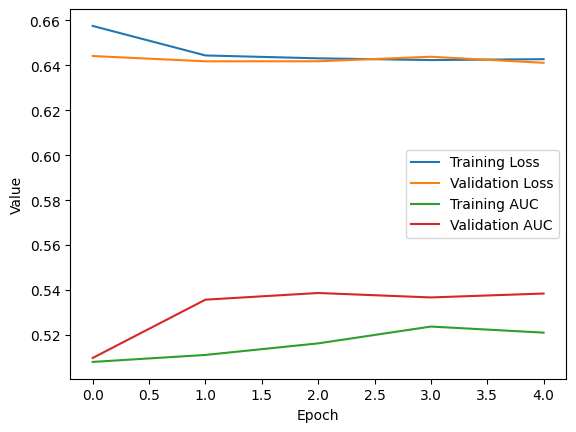

In [94]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [95]:
# Load the best weights into the final model
final_model = create_model()
final_model.load_weights(best_fold_weights_path)

predictions = final_model.predict(X_test)

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [96]:
create_submission(testing_ids, predictions, "nn")

# **Conclusion**

With the acclimation of school, work, marathon training, and other projects, I unfortunately do not have the time I would like to be able to continue building upon my models and features for submission. That being said, I gave the problem a fair crack with 20+ submissions and have achieved around a 0.539 for the cross-validation set of 70% of the testing data that they provide.

I utilized several basic powerhouse models including the logistic regression, x-gradient boosting, random forests, ensemble stacking, and artificial neural networks. Outside of the modeling that has been completed here, there are several areas I would have liked to have seen improvements on:

I would have liked to focus more time on the following feature creation, modeling, and tuning:
    * Oversampling the low 3pt percentage makes.
    * Convolutional neural networks of player locations at the time the shot was put up.
    * Graph CNNs
    * Hyperparamater tuning experimentation with feature selection. I felt unsatisfied with my approach.
    
At the end of the day, while I wasn't able to get the models where I would have liked with my busy schedule and need to teach myself new technques, I am proud to say that I learned plenty of new things. One thing I was very proud of from my analysis that had top-level significance in all of the modeling was the defensive density metric that I developed:

$$
\text{DEF_DENS} = \sum_{{i=1}}^{n} \left( 0.83^{\text{Distance}_{\text{Shooter}, i}} \times 1.01^{\text{Angle}_{\text{Shooter}, i}}\right) * \text{Shooter Distance to Basket}
$$

where we focus on the summation of two exponential values of defensive distance and angle of i player to the shooter multiplied by the shooter's distance to the basket.

I hope that someone can take some information from my analysis for their own learning and/or application.

![Gohlke](https://media.cnn.com/api/v1/images/stellar/prod/gettyimages-2102954533.jpg?c=16x9&q=h_653,w_1160,c_fill/f_webp)